In [23]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgbm
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
def mape(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    z = np.mean(np.abs((y_true-y_pred)/y_true))
    return z
from sklearn.metrics import make_scorer, silhouette_score
mapes = make_scorer(mape)
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, IsolationForest, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor,LocalOutlierFactor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures, RobustScaler,StandardScaler,PowerTransformer,QuantileTransformer,MinMaxScaler, LabelEncoder,OneHotEncoder, FunctionTransformer, quantile_transform, power_transform
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import normaltest, zscore
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, RANSACRegressor, BayesianRidge, LassoCV, ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV, OrthogonalMatchingPursuit,RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.manifold import TSNE
from sklearn.pipeline import FeatureUnion
import catboost as cb
from sklearn.svm import SVR, OneClassSVM
from sklearn.base import TransformerMixin
from sklearn.decomposition import KernelPCA
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectFromModel,mutual_info_regression

In [24]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [31]:
data_train_x = data_train.iloc[:,2:]
data_train_y = data_train.iloc[:,1]
cat_feature = data_train_x.iloc[:,:10]
num_feature = data_train_x.iloc[:,10:]
data_test_x = data_test.iloc[:,1:]
cat_feature_col = cat_feature.columns
num_feature_col = num_feature.columns

In [32]:
col_want = ['Cat_02','Cat_04', 'Col_0005', 'Col_0248', 'Col_0271', 'Col_0380', 'Col_0590',
       'Col_0592', 'Col_0685', 'Col_0695', 'Col_0712', 'Col_0717', 'Col_0720',
       'Col_0804', 'Col_0816', 'Col_1002', 'Col_1044', 'Col_1058', 'Col_1078',
       'Col_1091', 'Col_1135', 'Col_1188', 'Col_1315', 'Col_1485', 'Col_1683',
       'Col_1845', 'Col_1939', 'Col_2175', 'Col_2581', 'Col_2643', 'Col_2969',
       'Col_3080', 'Col_3166', 'Col_3841', 'Col_3848', 'Col_3867', 'Col_3871',
       'Col_3874', 'Col_3875', 'Col_3970', 'Col_4181', 'Col_0443',
       'Col_0566', 'Col_0606',
       'Col_0739', 'Col_0855', 'Col_0871',
       'Col_0921', 'Col_1121', 'Col_1182',
       'Col_1196', 'Col_1265', 'Col_1522',
       'Col_1564', 'Col_1636', 'Col_1772',
       'Col_1912', 'Col_1978', 'Col_2041',
       'Col_2046', 'Col_2280', 'Col_2570',
       'Col_2723', 'Col_2730', 'Col_2841',
       'Col_2985', 'Col_3202', 'Col_3234',
       'Col_3342', 'Col_3396', 'Col_3459',
       'Col_3631', 'Col_3696', 'Col_3704',
       'Col_4026', 'Col_4109', 'Col_4160', 'Col_0225']
data_train_x_want = data_train_x[col_want]
cat_feature_want = col_want[:2]
num_feature_want = col_want[2:]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


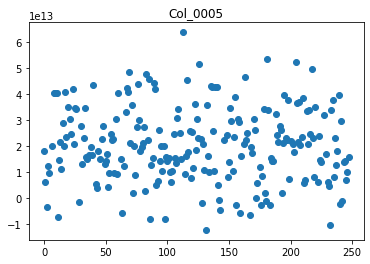

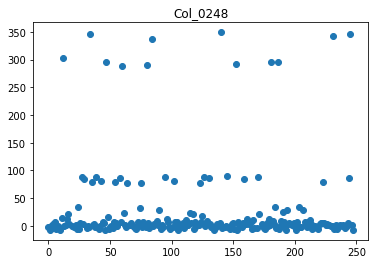

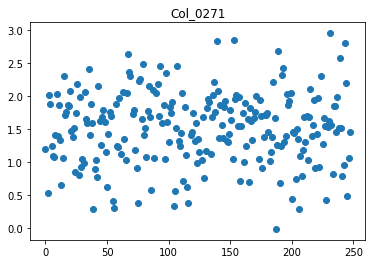

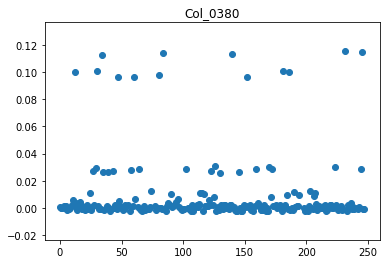

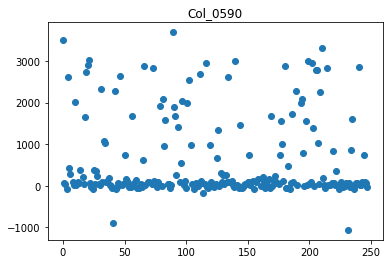

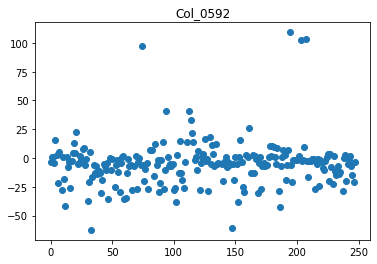

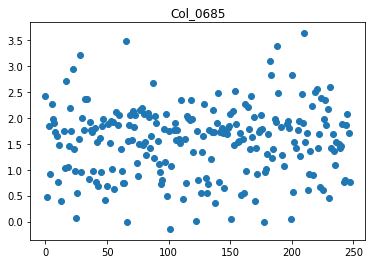

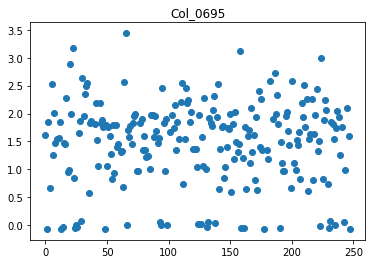

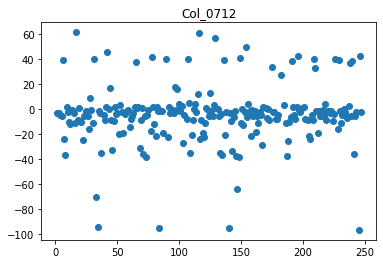

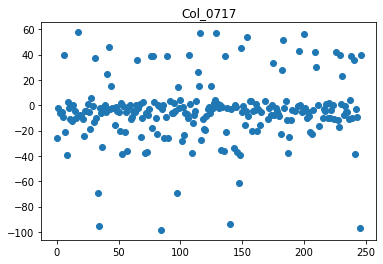

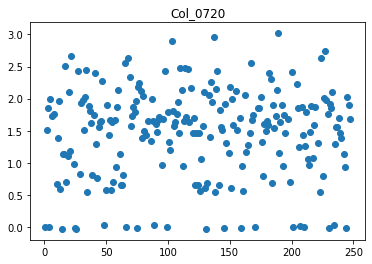

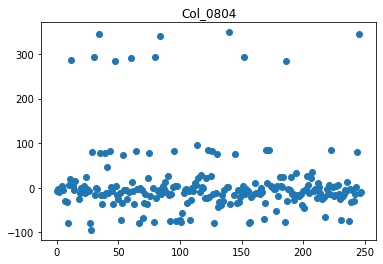

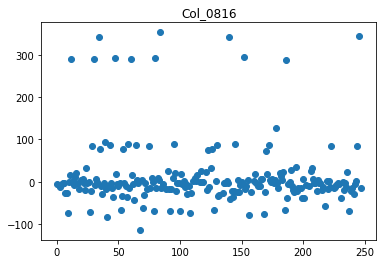

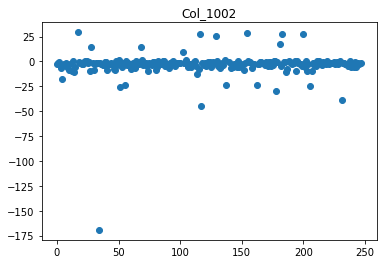

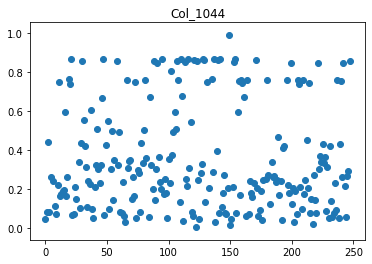

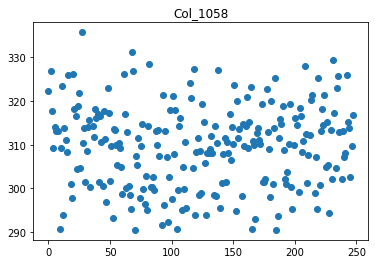

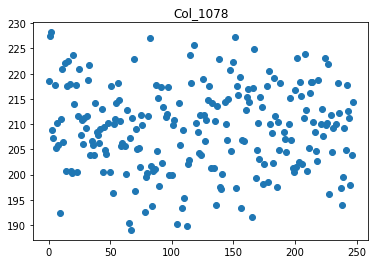

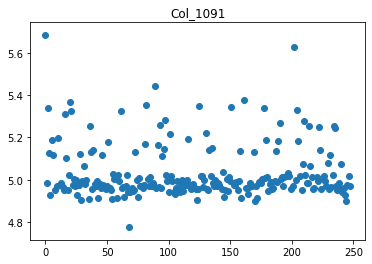

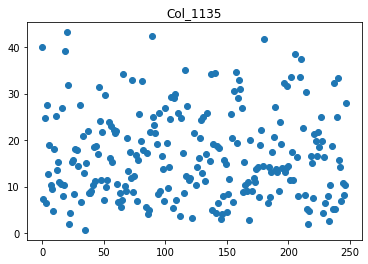

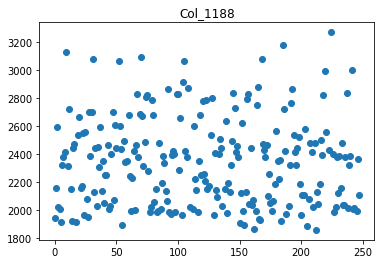

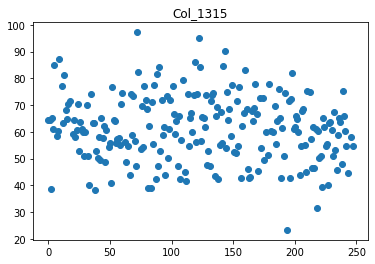

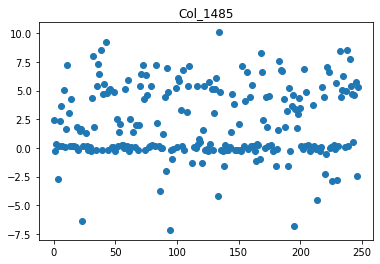

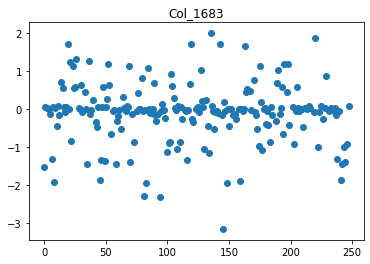

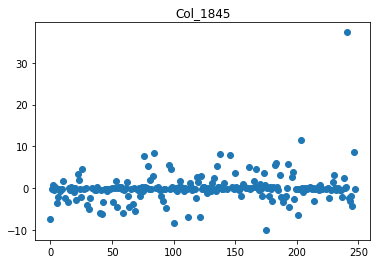

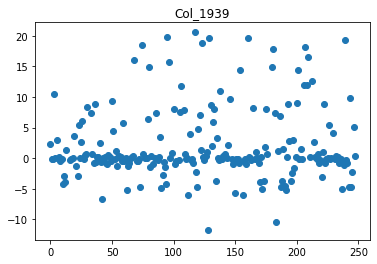

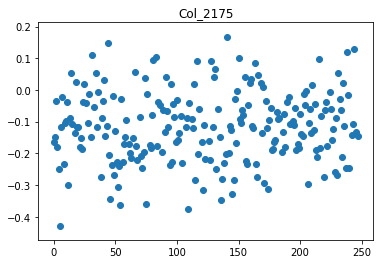

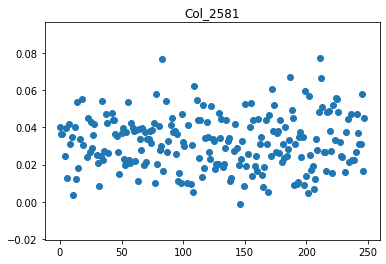

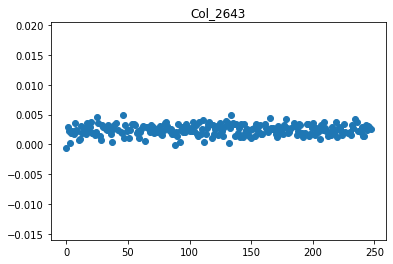

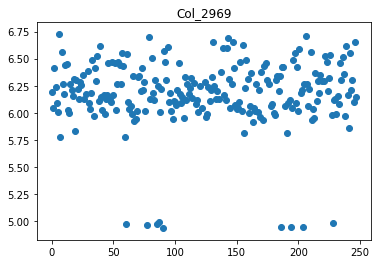

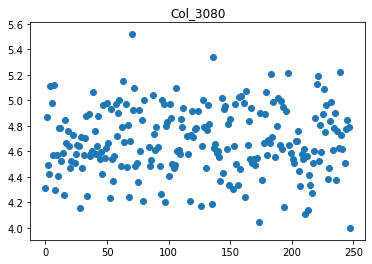

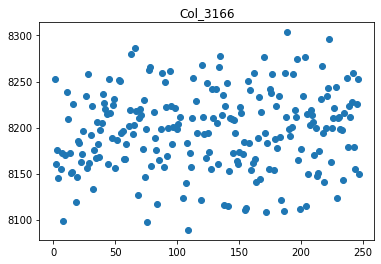

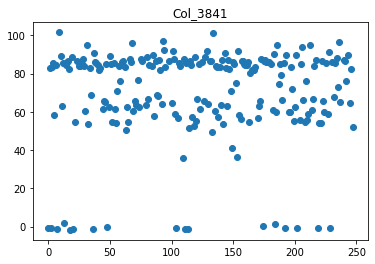

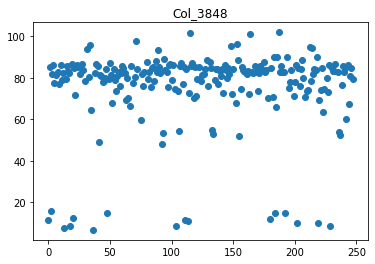

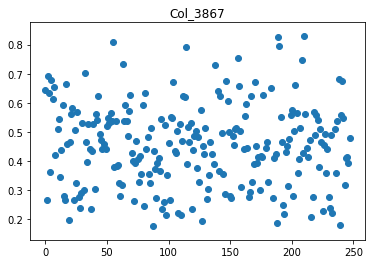

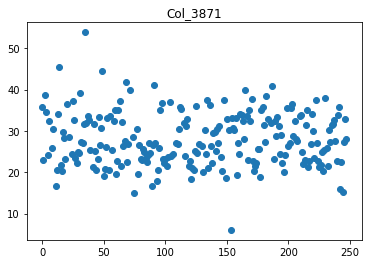

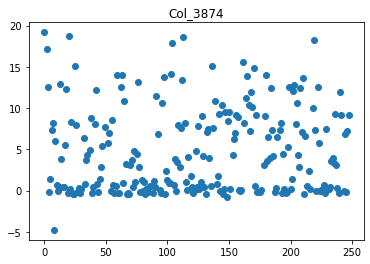

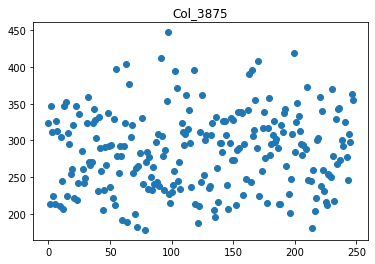

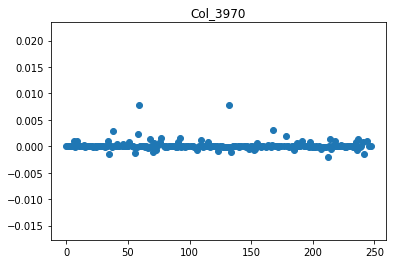

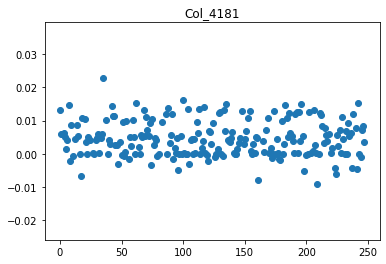

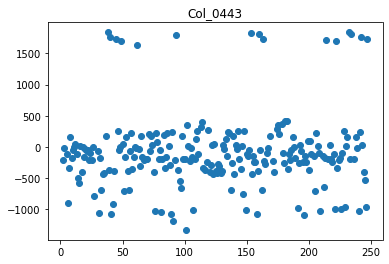

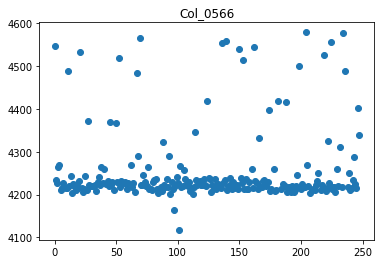

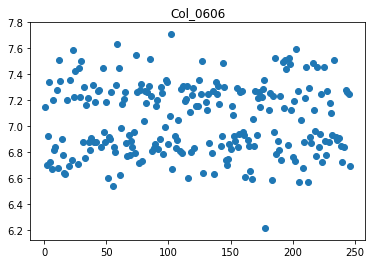

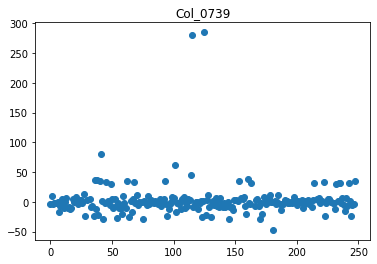

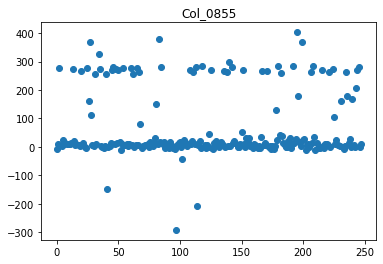

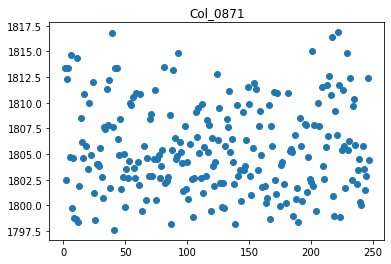

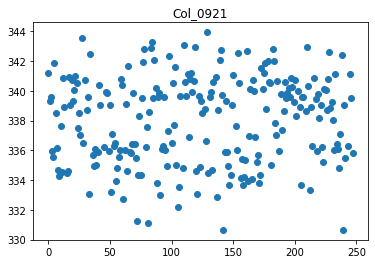

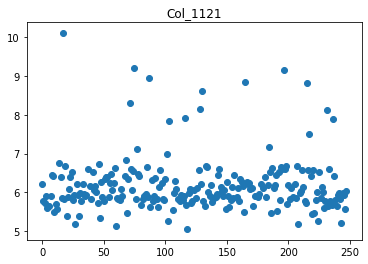

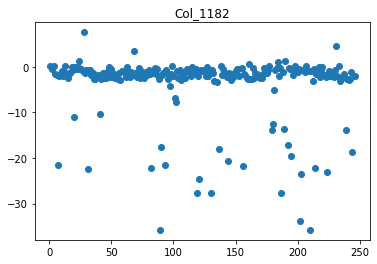

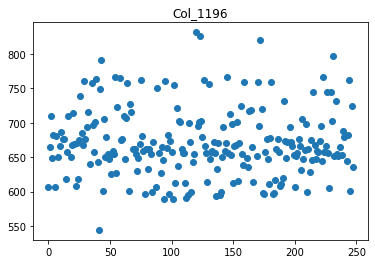

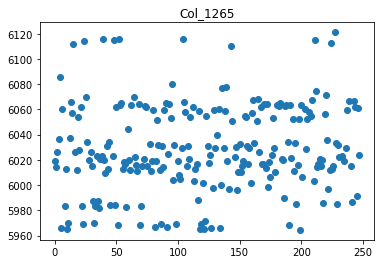

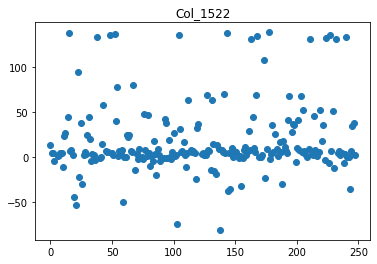

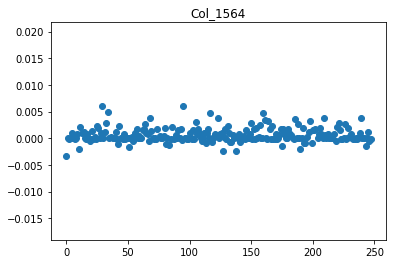

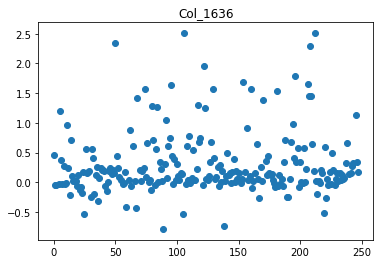

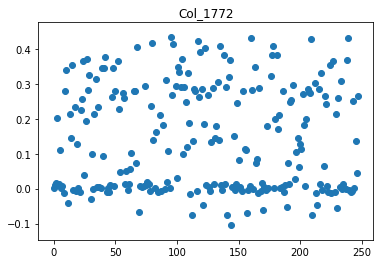

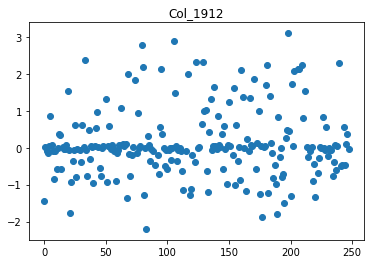

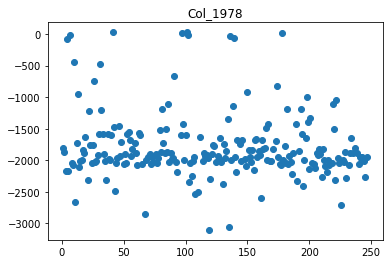

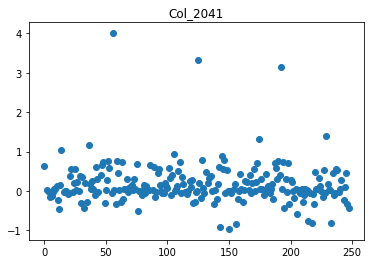

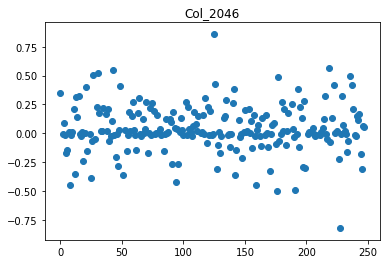

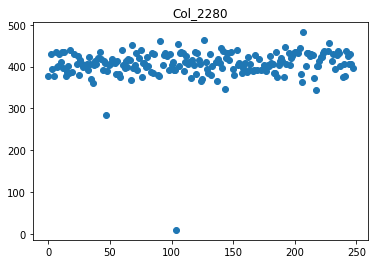

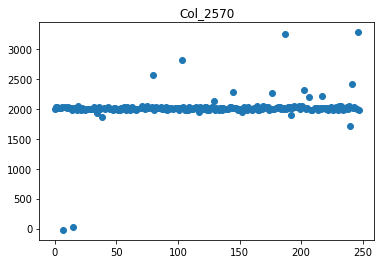

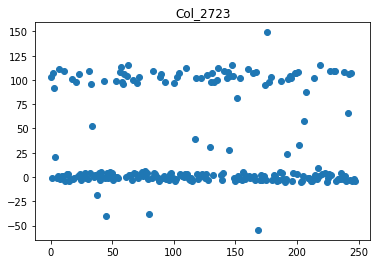

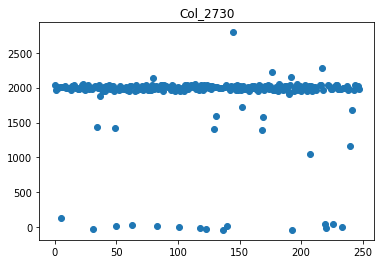

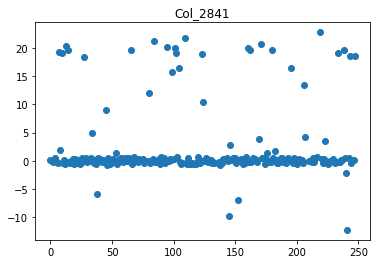

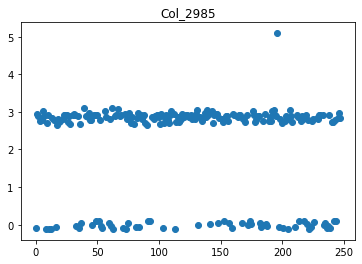

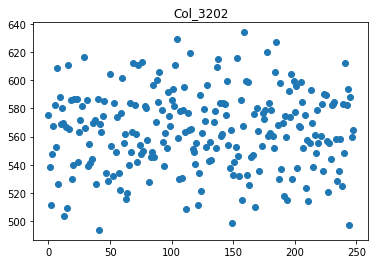

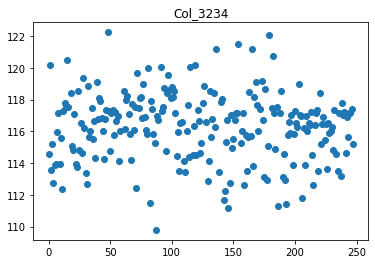

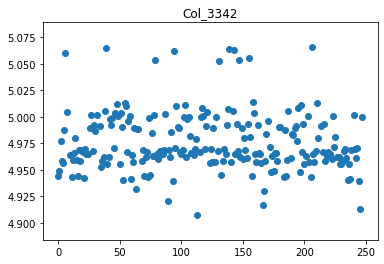

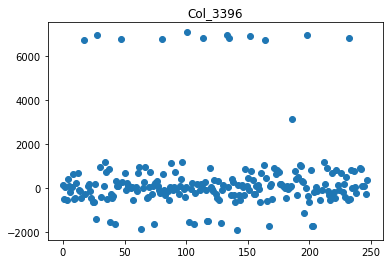

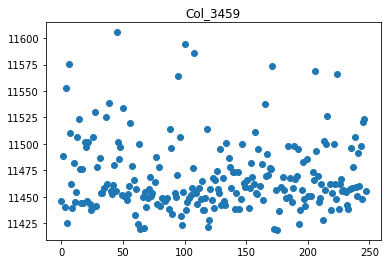

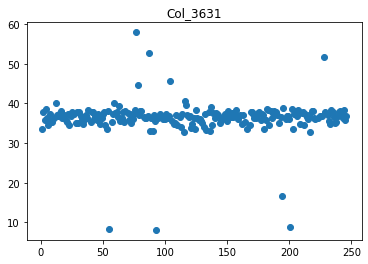

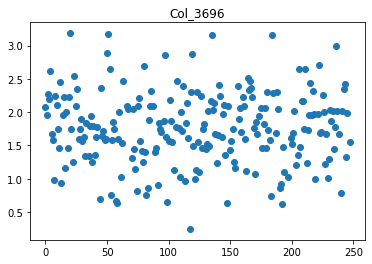

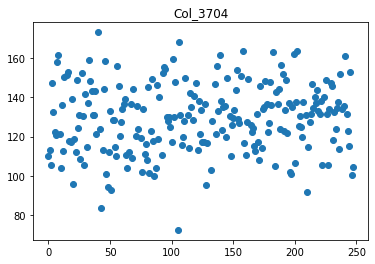

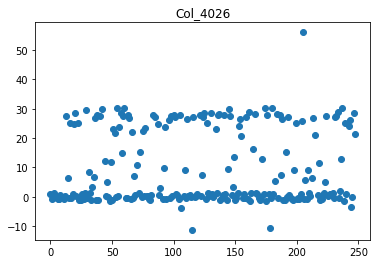

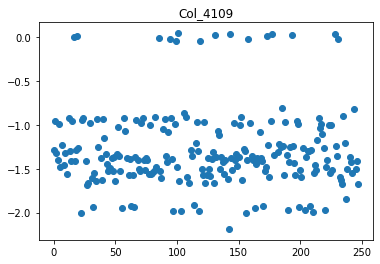

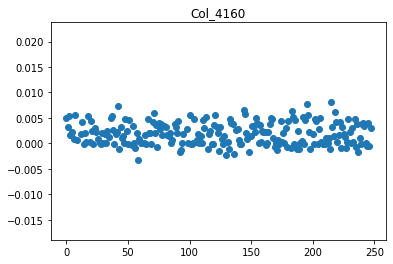

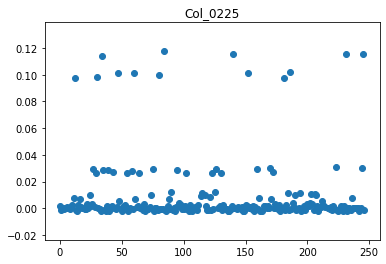

In [34]:
for i in range(2,data_train_x_want.shape[1]):
    plt.figure()
    plt.scatter(data_train_x_want.index,data_train_x_want.iloc[:,i])
    plt.title(data_train_x_want.columns[i])

In [21]:
##############################ensemble use lasso+omp sel try impute cv################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    #('imputer',KNNImputer(n_neighbors = 6,add_indicator=True))
    ('imputer',IterativeImputer(estimator=BayesianRidge(),add_indicator=True,max_iter=50,verbose=3))
])
num_transform2 = Pipeline(steps=[
    ('scalar',StandardScaler()),
    #('imputer',KNNImputer(n_neighbors = 6,add_indicator=True))
    ('imputer',IterativeImputer(estimator=GaussianMixture(),add_indicator=True,max_iter=50,verbose=3))
])
num_transform3 = Pipeline(steps=[
    ('scalar',StandardScaler()),
    #('imputer',KNNImputer(n_neighbors = 6,add_indicator=True))
    ('imputer',IterativeImputer(estimator=KNeighborsRegressor(80),add_indicator=True,max_iter=50,verbose=3))
])
num_transform4 = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 6,add_indicator=True))
    #('imputer',IterativeImputer(estimator=SVR(),add_indicator=True,max_iter=50,verbose=3))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature_want),
    ('num',num_transform,num_feature_want)
])
preprocess2 = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature_want),
    ('num',num_transform2,num_feature_want)
])
preprocess3 = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature_want),
    ('num',num_transform3,num_feature_want)
])
preprocess4 = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature_want),
    ('num',num_transform4,num_feature_want)
])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])

# l = LassoCV(cv=10)
# ll = LassoLarsCV(cv=10)
# rr = RidgeCV(cv=10)
# svr = SVR(kernel='linear')
# omp = OrthogonalMatchingPursuitCV(cv=10)
# xg = xgb.XGBRegressor(objective='reg:squarederror')
# l2 = LassoCV(cv=10)
# stack = StackingRegressor(regressors=(omp,ll,rr,xg,svr,l),
#                            meta_regressor=l2,
#                            verbose=1)

pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('polyfeature',polyfeature),
    #('stack',stack)
    ('omp',OrthogonalMatchingPursuit(n_nonzero_coefs=11))
])
pipe2 = Pipeline(steps=[
    ('preprocess',preprocess2),
    ('polyfeature',polyfeature),
    #('stack',stack)
    ('omp',OrthogonalMatchingPursuit(n_nonzero_coefs=11))
])
pipe3 = Pipeline(steps=[
    ('preprocess',preprocess3),
    ('polyfeature',polyfeature),
    #('stack',stack)
    ('omp',OrthogonalMatchingPursuit(n_nonzero_coefs=11))
])


er = VotingRegressor([('1',pipe),
                      ('2',pipe2),
                      ('3',pipe3),
])
cvsmape = cross_val_score(er,data_train_x_want,data_train_y,cv=10,scoring=mapes)
cvsmse = cross_val_score(er,data_train_x_want,data_train_y,cv=10,scoring='neg_mean_squared_error')
print(cvsmape.mean(),cvsmape.std(),1-cvsmape.mean())
print(-cvsmse.mean(),cvsmse.std())

[IterativeImputer] Completing matrix with shape (223, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 2.09
[IterativeImputer] Change: 4.891392133284365, scaled tolerance: 0.011866461126212108 
[IterativeImputer] Ending imputation round 2/50, elapsed time 4.63
[IterativeImputer] Change: 1.0936348246241199, scaled tolerance: 0.011866461126212108 
[IterativeImputer] Ending imputation round 3/50, elapsed time 7.13
[IterativeImputer] Change: 0.215507940560246, scaled tolerance: 0.011866461126212108 
[IterativeImputer] Ending imputation round 4/50, elapsed time 8.68
[IterativeImputer] Change: 0.14024041289039063, scaled tolerance: 0.011866461126212108 
[IterativeImputer] Ending imputation round 5/50, elapsed time 10.77
[IterativeImputer] Change: 0.1146651208491064, scaled tolerance: 0.011866461126212108 
[IterativeImputer] Ending imputation round 6/50, elapsed time 12.83
[IterativeImputer] Change: 0.0915781707279388, scaled tolerance: 0.011866461126212108 
[IterativeImputer

[IterativeImputer] Ending imputation round 1/50, elapsed time 0.17
[IterativeImputer] Change: 1.3441969972714332, scaled tolerance: 0.010840519751282456 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.38
[IterativeImputer] Change: 0.17073905041910026, scaled tolerance: 0.010840519751282456 
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.54
[IterativeImputer] Change: 0.07787150716285426, scaled tolerance: 0.010840519751282456 
[IterativeImputer] Ending imputation round 4/50, elapsed time 0.75
[IterativeImputer] Change: 0.04720394657648797, scaled tolerance: 0.010840519751282456 
[IterativeImputer] Ending imputation round 5/50, elapsed time 0.91
[IterativeImputer] Change: 0.012305560532830492, scaled tolerance: 0.010840519751282456 
[IterativeImputer] Ending imputation round 6/50, elapsed time 1.12
[IterativeImputer] Change: 0.0, scaled tolerance: 0.010840519751282456 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing mat

[IterativeImputer] Ending imputation round 19/50, elapsed time 3.67
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 20/50, elapsed time 3.84
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 21/50, elapsed time 4.01
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 22/50, elapsed time 4.23
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 23/50, elapsed time 4.38
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 24/50, elapsed time 4.57
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 25/50, elapsed time 4.78
[I

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



[IterativeImputer] Ending imputation round 13/15, elapsed time 0.15
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.16
[IterativeImputer] Ending imputation round 15/15, elapsed time 0.17
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.03
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.05
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.09
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.12
[IterativeImputer] Ending imputation round 4/50, elapsed time 0.18
[IterativeImputer] Ending imputation round 5/50, elapsed time 0.24
[IterativeImputer] Ending imputation round 6/50, elapsed time 0.29
[IterativeImputer] Ending imputation round 7/50, elapsed time 0.34
[IterativeImputer] Ending imputation round 8/50, elapsed time 0.38
[IterativeImputer] Ending imputation round 9/50, elapsed time 0.41
[IterativeIm

[IterativeImputer] Ending imputation round 29/50, elapsed time 62.74
[IterativeImputer] Change: 0.016868922815289095, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 30/50, elapsed time 64.61
[IterativeImputer] Change: 0.015801118697560325, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 31/50, elapsed time 66.95
[IterativeImputer] Change: 0.014800965975443467, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 32/50, elapsed time 68.78
[IterativeImputer] Change: 0.01386417367242293, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 33/50, elapsed time 71.08
[IterativeImputer] Change: 0.012986723386118754, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 34/50, elapsed time 73.88
[IterativeImputer] Change: 0.012164851934131759, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 35/50, ela

[IterativeImputer] Ending imputation round 46/50, elapsed time 8.59
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 47/50, elapsed time 8.76
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 48/50, elapsed time 8.95
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 49/50, elapsed time 9.17
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 50/50, elapsed time 9.32
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 


/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/35, elapsed time 0.02
[IterativeImputer] Ending imputation round 2/35, elapsed time 0.05
[IterativeImputer] Ending imputation round 3/35, elapsed time 0.07
[IterativeImputer] Ending imputation round 4/35, elapsed time 0.08
[IterativeImputer] Ending imputation round 5/35, elapsed time 0.09
[IterativeImputer] Ending imputation round 6/35, elapsed time 0.10
[IterativeImputer] Ending imputation round 7/35, elapsed time 0.11
[IterativeImputer] Ending imputation round 8/35, elapsed time 0.12
[IterativeImputer] Ending imputation round 9/35, elapsed time 0.13
[IterativeImputer] Ending imputation round 10/35, elapsed time 0.14
[IterativeImputer] Ending imputation round 11/35, elapsed time 0.15
[IterativeImputer] Ending imputation round 12/35, elapsed time 0.16
[IterativeImputer] Ending imputation round 13/35, elapsed time 0.17
[IterativeImputer] Ending imputation round 14/35, elapsed time 0.18


[IterativeImputer] Ending imputation round 15/50, elapsed time 28.38
[IterativeImputer] Change: 0.011180146027725279, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (223, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 1.77
[IterativeImputer] Change: 9.388541888092627e-14, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (223, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.20
[IterativeImputer] Change: 1.3955383069966754, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.40
[IterativeImputer] Change: 0.19380190409429315, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.56
[IterativeImputer] Change: 0.10719439666633208, scaled tolerance: 0.01204205705224389 
[Ite

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.10
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.11


[IterativeImputer] Ending imputation round 6/50, elapsed time 1.12
[IterativeImputer] Change: 0.0, scaled tolerance: 0.011879680018136274 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.10
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.10
[IterativeIm

[IterativeImputer] Ending imputation round 22/50, elapsed time 4.22
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 23/50, elapsed time 4.43
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 24/50, elapsed time 4.60
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 25/50, elapsed time 4.78
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 26/50, elapsed time 4.94
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 27/50, elapsed time 5.14
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 28/50, elapsed time 5.30
[IterativeImputer] C

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/18, elapsed time 0.02
[IterativeImputer] Ending imputation round 2/18, elapsed time 0.04
[IterativeImputer] Ending imputation round 3/18, elapsed time 0.06
[IterativeImputer] Ending imputation round 4/18, elapsed time 0.07
[IterativeImputer] Ending imputation round 5/18, elapsed time 0.09
[IterativeImputer] Ending imputation round 6/18, elapsed time 0.10
[IterativeImputer] Ending imputation round 7/18, elapsed time 0.11
[IterativeImputer] Ending imputation round 8/18, elapsed time 0.12
[IterativeImputer] Ending imputation round 9/18, elapsed time 0.13
[IterativeImputer] Ending imputation round 10/18, elapsed time 0.14
[IterativeImputer] Ending imputation round 11/18, elapsed time 0.15
[IterativeImputer] Ending imputation round 12/18, elapsed time 0.16
[IterativeImputer] Ending imputation round 13/18, elapsed time 0.17
[IterativeImputer] Ending imputation round 14/18, elapsed time 0.18


[IterativeImputer] Ending imputation round 5/50, elapsed time 0.99
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 6/50, elapsed time 1.15
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 7/50, elapsed time 1.34
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 8/50, elapsed time 1.54
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 9/50, elapsed time 1.71
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 10/50, elapsed time 1.84
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 11/50, elapsed time 2.04
[

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/16, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/16, elapsed time 0.03
[IterativeImputer] Ending imputation round 3/16, elapsed time 0.04
[IterativeImputer] Ending imputation round 4/16, elapsed time 0.05
[IterativeImputer] Ending imputation round 5/16, elapsed time 0.06
[IterativeImputer] Ending imputation round 6/16, elapsed time 0.07
[IterativeImputer] Ending imputation round 7/16, elapsed time 0.08
[IterativeImputer] Ending imputation round 8/16, elapsed time 0.08
[IterativeImputer] Ending imputation round 9/16, elapsed time 0.10
[IterativeImputer] Ending imputation round 10/16, elapsed time 0.11
[IterativeImputer] Ending imputation round 11/16, elapsed time 0.12
[IterativeImputer] Ending imputation round 12/16, elapsed time 0.14
[IterativeImputer] Ending imputation round 13/16, elapsed time 0.15
[IterativeImputer] Ending imputation round 14/16, elapsed time 0.16


[IterativeImputer] Ending imputation round 5/50, elapsed time 0.96
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 6/50, elapsed time 1.14
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 7/50, elapsed time 1.34
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 8/50, elapsed time 1.53
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 9/50, elapsed time 1.69
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 10/50, elapsed time 1.92
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 11/50, elapsed time 

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (24, 76)
[IterativeImputer] Ending imputation round 1/16, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/16, elapsed time 0.03
[IterativeImputer] Ending imputation round 3/16, elapsed time 0.05
[IterativeImputer] Ending imputation round 4/16, elapsed time 0.06
[IterativeImputer] Ending imputation round 5/16, elapsed time 0.08
[IterativeImputer] Ending imputation round 6/16, elapsed time 0.09
[IterativeImputer] Ending imputation round 7/16, elapsed time 0.10
[IterativeImputer] Ending imputation round 8/16, elapsed time 0.11
[IterativeImputer] Ending imputation round 9/16, elapsed time 0.12
[IterativeImputer] Ending imputation round 10/16, elapsed time 0.13
[IterativeImputer] Ending imputation round 11/16, elapsed time 0.15
[IterativeImputer] Ending imputation round 12/16, elapsed time 0.16
[IterativeImputer] Ending imputation round 13/16, elapsed time 0.17
[IterativeImputer] Ending imputation round 14/16, elapsed time 0.18


[IterativeImputer] Ending imputation round 5/50, elapsed time 0.94
[IterativeImputer] Change: 0.03192557523967299, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 6/50, elapsed time 1.15
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 7/50, elapsed time 1.33
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 8/50, elapsed time 1.50
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 9/50, elapsed time 1.72
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 10/50, elapsed time 1.91
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 11/50, elapsed time 2

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (24, 76)
[IterativeImputer] Ending imputation round 1/16, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/16, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/16, elapsed time 0.04
[IterativeImputer] Ending imputation round 4/16, elapsed time 0.06
[IterativeImputer] Ending imputation round 5/16, elapsed time 0.07
[IterativeImputer] Ending imputation round 6/16, elapsed time 0.08
[IterativeImputer] Ending imputation round 7/16, elapsed time 0.08
[IterativeImputer] Ending imputation round 8/16, elapsed time 0.09
[IterativeImputer] Ending imputation round 9/16, elapsed time 0.10
[IterativeImputer] Ending imputation round 10/16, elapsed time 0.10
[IterativeImputer] Ending imputation round 11/16, elapsed time 0.11
[IterativeImputer] Ending imputation round 12/16, elapsed time 0.11
[IterativeImputer] Ending imputation round 13/16, elapsed time 0.12
[IterativeImputer] Ending imputation round 14/16, elapsed time 0.13


[IterativeImputer] Ending imputation round 12/15, elapsed time 0.15
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.16
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.17
[IterativeImputer] Ending imputation round 15/15, elapsed time 0.19
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.05
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.07
[IterativeImputer] Ending imputation round 2/5, elapsed time 0.11
[IterativeImputer] Ending imputation round 3/5, elapsed time 0.14
[IterativeImputer] Ending imputation round 4/5, elapsed time 0.20
[IterativeImputer] Ending imputation round 5/5, elapsed time 0.26
[IterativeImputer] Completing matrix with shape (223, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 1.83
[IterativeImputer] Change: 6.236780639793302, scaled tolerance: 0.010840519751282456 
[Iterat

[IterativeImputer] Ending imputation round 11/50, elapsed time 24.16
[IterativeImputer] Change: 0.0254790986014433, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 12/50, elapsed time 27.08
[IterativeImputer] Change: 0.020392098487953376, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 13/50, elapsed time 29.97
[IterativeImputer] Change: 0.016319685035207674, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 14/50, elapsed time 31.84
[IterativeImputer] Change: 0.013056997464706597, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 15/50, elapsed time 33.08
[IterativeImputer] Change: 0.010447334475004837, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (223, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 1.93
[IterativeImputer] Change: 1.2795063358

[IterativeImputer] Ending imputation round 48/50, elapsed time 8.82
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 49/50, elapsed time 9.04
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 
[IterativeImputer] Ending imputation round 50/50, elapsed time 9.20
[IterativeImputer] Change: 0.09367448419530153, scaled tolerance: 0.01186436543345526 


/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.10
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.11
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.13
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.14
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.15
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.16
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.17
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.18
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.19


[IterativeImputer] Ending imputation round 24/50, elapsed time 55.94
[IterativeImputer] Change: 0.02339492647570572, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 25/50, elapsed time 58.16
[IterativeImputer] Change: 0.021913172884936764, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 26/50, elapsed time 59.91
[IterativeImputer] Change: 0.02052565518426011, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 27/50, elapsed time 62.75
[IterativeImputer] Change: 0.019226125993248803, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 28/50, elapsed time 64.86
[IterativeImputer] Change: 0.01800896052498039, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 29/50, elapsed time 66.77
[IterativeImputer] Change: 0.016868922815289095, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 30/50, elaps

[IterativeImputer] Ending imputation round 40/50, elapsed time 7.60
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 41/50, elapsed time 7.79
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 42/50, elapsed time 7.98
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 43/50, elapsed time 8.18
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 44/50, elapsed time 8.39
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 45/50, elapsed time 8.56
[IterativeImputer] Change: 0.07968814926908994, scaled tolerance: 0.011618415519767415 
[IterativeImputer] Ending imputation round 46/50, elapsed time 8

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Ending imputation round 13/35, elapsed time 0.13
[IterativeImputer] Ending imputation round 14/35, elapsed time 0.15
[IterativeImputer] Ending imputation round 15/35, elapsed time 0.16
[IterativeImputer] Ending imputation round 16/35, elapsed time 0.17
[IterativeImputer] Ending imputation round 17/35, elapsed time 0.18
[IterativeImputer] Ending imputation round 18/35, elapsed time 0.19
[IterativeImputer] Ending imputation round 19/35, elapsed time 0.20
[IterativeImputer] Ending imputation round 20/35, elapsed time 0.21
[IterativeImputer] Ending imputation round 21/35, elapsed time 0.22
[IterativeImputer] Ending imputation round 22/35, elapsed time 0.23
[IterativeImputer] Ending imputation round 23/35, elapsed time 0.24
[IterativeImputer] Ending imputation round 24/35, elapsed time 0.25
[IterativeImputer] Ending imputation round 25/35, elapsed time 0.27
[IterativeImputer] Ending imputation round 26/35, elapsed time 0.28
[IterativeImputer] Ending imputation round 27/35

[IterativeImputer] Ending imputation round 3/50, elapsed time 0.58
[IterativeImputer] Change: 0.10719439666633208, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 4/50, elapsed time 0.79
[IterativeImputer] Change: 0.022863966361331867, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 5/50, elapsed time 0.95
[IterativeImputer] Change: 0.018559324947385318, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 6/50, elapsed time 1.14
[IterativeImputer] Change: 0.018559324947385318, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 7/50, elapsed time 1.33
[IterativeImputer] Change: 0.018559324947385318, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 8/50, elapsed time 1.55
[IterativeImputer] Change: 0.018559324947385318, scaled tolerance: 0.01204205705224389 
[IterativeImputer] Ending imputation round 9/50, elapsed time 1.72
[Ite

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.10
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.11
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.12
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.13
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.14
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.15
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.16
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.16
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.17
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.17


[IterativeImputer] Ending imputation round 6/50, elapsed time 1.30
[IterativeImputer] Change: 0.0, scaled tolerance: 0.011879680018136274 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.10
[IterativeIm

[IterativeImputer] Ending imputation round 22/50, elapsed time 4.11
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 23/50, elapsed time 4.29
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 24/50, elapsed time 4.45
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 25/50, elapsed time 4.68
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 26/50, elapsed time 4.87
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 27/50, elapsed time 5.13
[IterativeImputer] Change: 0.0402046172952857, scaled tolerance: 0.011850294660389 
[IterativeImputer] Ending imputation round 28/50, elapsed time 5.33
[IterativeImputer] C

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Ending imputation round 15/18, elapsed time 0.16
[IterativeImputer] Ending imputation round 16/18, elapsed time 0.17
[IterativeImputer] Ending imputation round 17/18, elapsed time 0.18
[IterativeImputer] Ending imputation round 18/18, elapsed time 0.19
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.02
[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.06
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.11
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.15
[IterativeImputer] Ending imputation round 4/50, elapsed time 0.18
[IterativeImputer] Ending imputation round 5/50, elapsed time 0.22
[IterativeImputer] Ending imputation round 6/50, elapsed time 0.28
[IterativeImputer] Ending imputation round 7/50, elapsed time 0.34
[IterativeImputer] Ending imputation round 8/50, elapsed time 0.40
[IterativeIm

[IterativeImputer] Ending imputation round 12/50, elapsed time 2.31
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 13/50, elapsed time 2.49
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 14/50, elapsed time 2.72
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 15/50, elapsed time 2.89
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 16/50, elapsed time 3.11
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 17/50, elapsed time 3.29
[IterativeImputer] Change: 0.04760472759070849, scaled tolerance: 0.011925607833344253 
[IterativeImputer] Ending imputation round 18/50, elapsed time 3

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (25, 76)
[IterativeImputer] Ending imputation round 1/16, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/16, elapsed time 0.03
[IterativeImputer] Ending imputation round 3/16, elapsed time 0.06
[IterativeImputer] Ending imputation round 4/16, elapsed time 0.07
[IterativeImputer] Ending imputation round 5/16, elapsed time 0.09
[IterativeImputer] Ending imputation round 6/16, elapsed time 0.10
[IterativeImputer] Ending imputation round 7/16, elapsed time 0.11
[IterativeImputer] Ending imputation round 8/16, elapsed time 0.12
[IterativeImputer] Ending imputation round 9/16, elapsed time 0.13
[IterativeImputer] Ending imputation round 10/16, elapsed time 0.14
[IterativeImputer] Ending imputation round 11/16, elapsed time 0.15
[IterativeImputer] Ending imputation round 12/16, elapsed time 0.16
[IterativeImputer] Ending imputation round 13/16, elapsed time 0.18
[IterativeImputer] Ending imputation round 14/16, elapsed time 0.19


[IterativeImputer] Ending imputation round 5/50, elapsed time 1.02
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 6/50, elapsed time 1.19
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 7/50, elapsed time 1.38
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 8/50, elapsed time 1.59
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 9/50, elapsed time 1.75
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 10/50, elapsed time 1.94
[IterativeImputer] Change: 0.059109762301993614, scaled tolerance: 0.011851117452596404 
[IterativeImputer] Ending imputation round 11/50, elapsed time 

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Ending imputation round 8/16, elapsed time 0.13
[IterativeImputer] Ending imputation round 9/16, elapsed time 0.15
[IterativeImputer] Ending imputation round 10/16, elapsed time 0.16
[IterativeImputer] Ending imputation round 11/16, elapsed time 0.17
[IterativeImputer] Ending imputation round 12/16, elapsed time 0.18
[IterativeImputer] Ending imputation round 13/16, elapsed time 0.19
[IterativeImputer] Ending imputation round 14/16, elapsed time 0.20
[IterativeImputer] Ending imputation round 15/16, elapsed time 0.21
[IterativeImputer] Ending imputation round 16/16, elapsed time 0.22
[IterativeImputer] Completing matrix with shape (24, 76)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.01
[IterativeImputer] Completing matrix with shape (24, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.03
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.08
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.14
[Iterativ

[IterativeImputer] Ending imputation round 8/50, elapsed time 1.46
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 9/50, elapsed time 1.64
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 10/50, elapsed time 1.86
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 11/50, elapsed time 2.05
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 12/50, elapsed time 2.22
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 13/50, elapsed time 2.43
[IterativeImputer] Change: 0.031925575239673015, scaled tolerance: 0.011829048404213303 
[IterativeImputer] Ending imputation round 14/50, elapsed ti

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



[IterativeImputer] Completing matrix with shape (24, 76)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.02
[IterativeImputer] Completing matrix with shape (24, 76)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.06
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.12
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.16
[IterativeImputer] Ending imputation round 4/50, elapsed time 0.20
[IterativeImputer] Ending imputation round 5/50, elapsed time 0.23
[IterativeImputer] Ending imputation round 6/50, elapsed time 0.26
[IterativeImputer] Ending imputation round 7/50, elapsed time 0.31
[IterativeImputer] Ending imputation round 8/50, elapsed time 0.37
[IterativeImputer] Ending imputation round 9/50, elapsed time 0.42
[IterativeImputer] Ending imputation round 10/50, elapsed time 0.46
[IterativeImputer] Ending imputation round 11/50, elapsed time 0.49
[IterativeImputer] Ending imputation round 12/50, elapsed time 0.52
[IterativeIm

In [19]:
##############################lasso sel poly2 omp cv################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    #('imputer',SimpleImputer(strategy='constant',add_indicator=True)),
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 6,add_indicator=True))#6
    #('imputer',IterativeImputer(estimator=LassoLars(),max_iter=50,sample_posterior=False,add_indicator=True,verbose=3))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature_col),
    ('num',num_transform,num_feature_col)
])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select_lassolars',SelectFromModel(LassoLarsCV(cv=10))),
    ('polyfeature',polyfeature),
    ('omp',OrthogonalMatchingPursuitCV(cv=10))
])
cvsmape = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring=mapes)
cvsmse = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring='neg_mean_squared_error')
print(cvsmape.mean(),cvsmape.std(),1-cvsmape.mean())
print(-cvsmse.mean(),cvsmse.std())

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.017e-01, with an active set of 35 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 60 iterations, i.e. alpha=8.024e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 60 iterations, i.e. alpha=8.024e-02, with an active set of 58 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=7.692e-02, with an active set of 52 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=5.034e-02, with an active set of 85 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 124 iterations, i.e. alpha=3.846e-02, with an active set of 110 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 116 iterations, i.e. alpha=4.742e-02, with an active set of 108 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 117 iterations, i.e. alpha=4.740e-02, with an active set of 109 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 184 iterations, i.e. alpha=2.370e-02, with an active set of 152 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 197 iterations, alpha=2.488e-02, previous alpha=2.488e-02, with an active set of 160 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 168 iterations, i.e. alpha=2.909e-02, with an active set of 144 regressors, and the smallest cholesky pivot element being 9.599e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 169 iterations, i.e. alpha=2.897e-02, with an active set of 145 regressors, and the smallest cholesky pivot element being 9.657e-08.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=5.142e-02, with an active set of 102 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 169 iterations, i.e. alpha=2.963e-02, with an active set of 137 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 191 iterations, i.e. alpha=2.542e-02, with an active set of 143 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=7.039e-02, with an active set of 75 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 113 iterations, i.e. alpha=4.751e-02, with an active set of 105 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 123 iterations, i.e. alpha=4.318e-02, with an active set of 115 regressors, and the smallest cholesky pivo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 343 iterations, alpha=9.617e-04, previous alpha=9.615e-04, with an active set of 200 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 115 iterations, i.e. alpha=3.820e-02, with an active set of 111 regressors, and the smallest cholesky pivot element being 9.064e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 138 iterations, i.e. alpha=3.022e-02, with an active set of 126 regressors, and the smallest cholesky pivot element being 9.306e-08.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 132 iterations, i.e. alpha=4.428e-02, with an active set of 118 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 151 iterations, i.e. alpha=3.617e-02, with an active set of 129 regressors, and the smallest cholesky pivot element being 7.376e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 153 iterations, i.e. alpha=3.613e-02, with an active set of 129 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 290 iterations, i.e. alpha=3.775e-03, with an active set of 192 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 291 iterations, i.e. alpha=3.775e-03, with an active set of 193 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 292 iterations, i.e. alpha=3.762e-03, with an active set of 194 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 261 iterations, i.e. alpha=4.975e-03, with an active set of 185 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 262 iterations, i.e. alpha=4.975e-03, with an active set of 186 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 262 iterations, i.e. alpha=4.975e-03, with an active set of 186 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 274 iterations, alpha=1.201e-02, previous alpha=1.201e-02, with an active set of 175 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=6.291e-02, with an active set of 76 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 100 iterations, i.e. alpha=5.627e-02, with an active set of 84 regressors, and the smallest cholesky pivot element being 6.909e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 100 iterations, i.e. alpha=5.617e-02, with an active set of 84 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=3.576e-02, with an active set of 117 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=3.575e-02, with an active set of 117 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 161 iterations, i.e. alpha=2.425e-02, with an active set of 141 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=7.335e-02, with an active set of 55 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=7.764e-02, with an active set of 60 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=7.037e-02, with an active set of 69 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 109 iterations, i.e. alpha=4.489e-02, with an active set of 95 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 114 iterations, alpha=4.373e-02, previous alpha=4.372e-02, with an active set of 99 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=8.299e-02, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.581e-08. Red

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=5.237e-02, with an active set of 88 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 99 iterations, i.e. alpha=5.236e-02, with an active set of 89 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 141 iterations, i.e. alpha=3.256e-02, with an active set of 127 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=5.604e-02, with an active set of 94 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=4.059e-02, with an active set of 114 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=4.058e-02, with an active set of 114 regressors, and the smallest cholesky pivo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=5.034e-02, with an active set of 85 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 124 iterations, i.e. alpha=3.846e-02, with an active set of 110 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 169 iterations, i.e. alpha=2.398e-02, with an active set of 141 regressors, and the smallest cholesky pivo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 184 iterations, i.e. alpha=2.370e-02, with an active set of 152 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 254 iterations, i.e. alpha=1.839e-02, with an active set of 162 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 271 iterations, alpha=1.749e-02, previous alpha=1.74

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 256 iterations, i.e. alpha=1.097e-02, with an active set of 176 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 257 iterations, i.e. alpha=1.097e-02, with an active set of 177 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 259 iterations, alpha=1.092e-02, previous alpha=1.09

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 191 iterations, i.e. alpha=2.542e-02, with an active set of 143 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 193 iterations, i.e. alpha=2.533e-02, with an active set of 145 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 220 iterations, i.e. alpha=2.347e-02, with an active set of 154 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 113 iterations, i.e. alpha=4.751e-02, with an active set of 105 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 123 iterations, i.e. alpha=4.318e-02, with an active set of 115 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 131 iterations, alpha=4.118e-02, previous alpha=4.10

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.071e-01, with an active set of 27 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 103 iterations, i.e. alpha=5.799e-02, with an active set of 83 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 115 iterations, i.e. alpha=3.820e-02, with an active set of 111 regressors, and the smallest cholesky pivot element being 9.064e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 138 iterations, i.e. alpha=3.022e-02, with an active set of 126 regressors, and the smallest cholesky pivot element being 9.306e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 155 iterations, i.e. alpha=2.594e-02, with an active set of 141 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 151 iterations, i.e. alpha=3.617e-02, with an active set of 129 regressors, and the smallest cholesky pivot element being 7.376e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 153 iterations, i.e. alpha=3.613e-02, with an active set of 129 regressors, and the smallest cholesky pivot element being 7.451e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 155 iterations, alpha=3.598e-02, previous alpha=3.59

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 290 iterations, i.e. alpha=3.775e-03, with an active set of 192 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 291 iterations, i.e. alpha=3.775e-03, with an active set of 193 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 292 iterations, i.e. alpha=3.762e-03, with an active set of 194 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 261 iterations, i.e. alpha=4.975e-03, with an active set of 185 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 262 iterations, i.e. alpha=4.975e-03, with an active set of 186 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 262 iterations, i.e. alpha=4.975e-03, with an active set of 186 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 274 iterations, alpha=1.201e-02, previous alpha=1.201e-02, with an active set of 175 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=6.291e-02, with an active set of 76 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 100 iterations, i.e. alpha=5.627e-02, with an active set of 84 regressors, and the smallest cholesky pivot element being 6.909e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 100 iterations, i.e. alpha=5.617e-02, with an active set of 84 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=3.576e-02, with an active set of 117 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=3.575e-02, with an active set of 117 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 161 iterations, i.e. alpha=2.425e-02, with an active set of 141 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=7.335e-02, with an active set of 55 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=7.764e-02, with an active set of 60 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=7.037e-02, with an active set of 69 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 109 iterations, i.e. alpha=4.489e-02, with an active set of 95 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 114 iterations, alpha=4.373e-02, previous alpha=4.372e-02, with an active set of 99 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=8.299e-02, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.581e-08. Red

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 210 iterations, alpha=2.851e-02, previous alpha=2.849e-02, with an active set of 145 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=5.237e-02, with an active set of 88 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 99 iterations, i.e. alpha=5.236e-02, with an active set of 89 regressors, and the smallest cholesky pivot element being 2.107e-08. Red

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

0.011454601034039242 0.0030805715277427673 0.9885453989659607
44.25046611075564 25.778340932189543


In [ ]:
def add_freq_encod(X):
    add_feature = pd.DataFrame()
    for col in cat_feature_col:
        fe = X.groupby(col).size()/len(X)
        add_feature.loc[:,col + '_freq_enocde'] = cat_feature[col].map(fe)
    return add_feature
add_freq_encoder = FunctionTransformer(add_freq_encod)

In [ ]:
class add_cluster(TransformerMixin):
    def __init__(self,model):
        self.model = model
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict(X))
        #return pd.concat([pd.DataFrame(X),pd.DataFrame(self.model.predict(X))],axis=1,ignore_index=True)

In [ ]:
################################preprocess pipeline#########################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])


In [ ]:
##############################add columns names################################
cat_pre_col = []
for i, col in enumerate(cat_feature_col):
    for j in range(data_test_x[col].nunique()):
        name = col+'_'+str(j)
        cat_pre_col.append(name)

for i, col in enumerate(cat_feature_col):
    for j in range(2):
        name = col+'_addindi'+str(j)
        cat_pre_col.append(name)
        
num_pre_col = num_feature_col.to_list()
for i, col in enumerate(num_feature_col.to_list()):
    name = col+'_addindi'
    num_pre_col.append(name)
    
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
])
x_add = pd.DataFrame(pipe.fit_transform(data_train_x))
x_add.columns = cat_pre_col+num_pre_col

In [ ]:
pd.set_option('display.max_columns', 500)
x_add.iloc[:,sel_mut[sel_mut>0.1].index].columns.tolist()

In [ ]:
##############################add poly columns names################################
sel_la = pd.read_csv('columns_selected_lassolars_addindicator_onehot.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
x_add_sel = x_add.iloc[:,choose_la]
pf = PolynomialFeatures(3)
x_add_sel_poly = pd.DataFrame(pf.fit_transform(x_add_sel))
x_add_sel_poly.columns = pf.get_feature_names(x_add_sel.columns)

In [ ]:
sel_la = pd.read_csv('columns_selected_omp_nonnormalize_addindicator_onehot_poly2_overselected_lassolars.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
x_add_sel_poly.iloc[:,choose_la].columns

In [ ]:
x_add_sel_poly

In [ ]:
id_want = [x_add.columns.get_loc(c) for c in ['Cat_02_3','Col_0005','Col_0248','Col_0271','Col_0380','Col_0590','Col_0592','Col_0685','Col_0720','Col_0804',
       'Col_0816','Col_1002','Col_1044','Col_1058','Col_1091','Col_1485','Col_1845','Col_1939','Col_2643','Col_2969'
       ,'Col_3848','Col_3875','Col_3970','Col_4181','Col_2723_addindi','Col_3631_addindi']]

In [ ]:
##############################try id_want stacking cross validation################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
def feature_select_omp(X):
    return  np.array(pd.DataFrame(X).iloc[:,id_want])
feature_selector_omp = FunctionTransformer(feature_select_omp)
feature_select_process_omp = Pipeline([('feature_select',feature_selector_omp)])

l = LassoCV(cv=3)
ll = LassoLarsCV(cv=3)
rr = RidgeCV(cv=3)
omp1 = OrthogonalMatchingPursuitCV(cv=3)
omp2 = OrthogonalMatchingPursuitCV(cv=5)
xg = xgb.XGBRegressor(objective='reg:squarederror')
stack = StackingCVRegressor(regressors=(omp1,ll,rr,l,xg),
                           meta_regressor=omp2,
                           verbose=1)
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select_omp',feature_select_process_omp),
    #('xg',xgb.XGBRegressor(objective='reg:squarederror'))
    #('en',ElasticNetCV(cv=3))
    #('RANSAC',RANSACRegressor(min_samples=60))
    #('ridge',RidgeCV(cv=10))
    ('stack',stack)
])


cvsmape = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring=mapes)
cvsmse = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring='neg_mean_squared_error')
print(cvsmape.mean(),cvsmape.std(),1-cvsmape.mean())
print(-cvsmse.mean(),cvsmse.std())

In [ ]:
##############################try id_want stacking to predict################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
def feature_select_omp(X):
    return  np.array(pd.DataFrame(X).iloc[:,id_want])
feature_selector_omp = FunctionTransformer(feature_select_omp)
feature_select_process_omp = Pipeline([('feature_select',feature_selector_omp)])

pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select_omp',feature_select_process_omp),
    #('xg',xgb.XGBRegressor(objective='reg:squarederror'))
    #('en',ElasticNetCV(cv=3))
    #('RANSAC',RANSACRegressor(min_samples=60))
    #('ridge',RidgeCV(cv=10))
    #('stack',stack)
])

l = LassoCV(cv=3)
ll = LassoLarsCV(cv=3)
rr = RidgeCV(cv=3)
omp1 = OrthogonalMatchingPursuitCV(cv=3)
omp2 = OrthogonalMatchingPursuitCV(cv=5)
xg = xgb.XGBRegressor(objective='reg:squarederror')
stack = StackingCVRegressor(regressors=(omp1,ll,rr,l,xg),
                           meta_regressor=omp2,
                           verbose=1)
x_stack_want = pipe.fit_transform(data_train_x)
stack.fit(x_stack_want,data_train_y)
data_private = pd.read_csv('test.csv')
data_private_x = data_test.iloc[:,1:]
y_pred_stack_want = stack.predict(pipe.transform(data_private_x))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(stack.predict(x_stack_want))
plt.plot(np.array(data_train_y))
1-mape(stack.predict(x_stack_want),data_train_y)

In [ ]:
##############################try id_want omp cross validation################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
def feature_select_omp(X):
    return  np.array(pd.DataFrame(X).iloc[:,id_want])
feature_selector_omp = FunctionTransformer(feature_select_omp)
feature_select_process_omp = Pipeline([('feature_select',feature_selector_omp)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select_omp',feature_select_process_omp),
    ('polyfeature',polyfeature),
    #('xg',xgb.XGBRegressor(objective='reg:squarederror'))
    #('en',ElasticNetCV(cv=3))
    #('RANSAC',RANSACRegressor(min_samples=60))
    #('ridge',RidgeCV(cv=10))
    ('ll',LassoLarsCV(cv=10))
    #('stack',stack)
    #('omp',OrthogonalMatchingPursuit(n_nonzero_coefs=26))
])

cvsmape = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring=mapes)
cvsmse = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring='neg_mean_squared_error')
print(cvsmape.mean(),cvsmape.std(),1-cvsmape.mean())
print(-cvsmse.mean(),cvsmse.std())

In [ ]:
##############################try id_want omp to predict################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
def feature_select_omp(X):
    return  np.array(pd.DataFrame(X).iloc[:,id_want])
feature_selector_omp = FunctionTransformer(feature_select_omp)
feature_select_process_omp = Pipeline([('feature_select',feature_selector_omp)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select_omp',feature_select_process_omp),
    ('polyfeature',polyfeature),
    #('xg',xgb.XGBRegressor(objective='reg:squarederror'))
    #('en',ElasticNetCV(cv=3))
    #('RANSAC',RANSACRegressor(min_samples=60))
    #('ridge',RidgeCV(cv=10))
    #('stack',stack)
])
omp_want = OrthogonalMatchingPursuit(cv=10)
x_omp_want = pipe.fit_transform(data_train_x)
omp_want.fit(x_omp_want,data_train_y)
data_private = pd.read_csv('test.csv')
data_private_x = data_test.iloc[:,1:]
y_pred_omp_want = omp_want.predict(pipe.transform(data_private_x))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(omp_want.predict(x_omp_want))
plt.plot(np.array(data_train_y))
1-mape(omp_want.predict(x_omp_want),data_train_y)

In [ ]:
pd.Series(omp_want.coef_)[pd.Series(omp_want.coef_)!=0]

In [ ]:
##############################try stacking cross validation################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
sel_la = pd.read_csv('columns_selected_lassolars_addindicator_onehot.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
def feature_select(X):
    return  pd.DataFrame(X).iloc[:,choose_la]
feature_selector = FunctionTransformer(feature_select)
feature_select_process = Pipeline([('feature_select',feature_selector)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])

l = LassoCV(cv=5)
ll = LassoLarsCV(cv=5)
rr = RidgeCV(cv=5)
omp1 = OrthogonalMatchingPursuitCV(cv=10)
omp2 = OrthogonalMatchingPursuitCV(cv=10)
xg = xgb.XGBRegressor(objective='reg:squarederror')
stack = StackingCVRegressor(regressors=(omp1,ll,rr,l,xg),
                           meta_regressor=omp2,
                           verbose=1)
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select',feature_select_process),
    #('polyfeature',polyfeature),
    #('feature_select_omp',SelectFromModel(OrthogonalMatchingPursuitCV(cv=10))),
    #('xg',xgb.XGBRegressor(objective='reg:squarederror'))
    #('en',ElasticNetCV(cv=10))
    #('RANSAC',RANSACRegressor(min_samples=60))
    #('ridge',RidgeCV(cv=10))
    ('stack',stack)
])

cvsmape = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring=mapes)
#cvsmse = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring='neg_mean_squared_error')
print(cvsmape.mean(),cvsmape.std(),1-cvsmape.mean())
#print(-cvsmse.mean(),cvsmse.std())

In [ ]:
##############################try stacking to predict################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
sel_la = pd.read_csv('columns_selected_lassolars_addindicator_onehot.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
def feature_select(X):
    return  pd.DataFrame(X).iloc[:,choose_la]
feature_selector = FunctionTransformer(feature_select)
feature_select_process = Pipeline([('feature_select',feature_selector)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])

pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select',feature_select_process),
    ('polyfeature',polyfeature),
    ('feature_select_omp',SelectFromModel(OrthogonalMatchingPursuitCV(cv=10))),
])

l = LassoCV(cv=5)
ll = LassoLarsCV(cv=5)
rr = RidgeCV(cv=5)
omp1 = OrthogonalMatchingPursuitCV(cv=10)
omp2 = OrthogonalMatchingPursuitCV(cv=10)
xg = xgb.XGBRegressor(objective='reg:squarederror')
stack = StackingCVRegressor(regressors=(omp1,ll,rr,l,xg),
                           meta_regressor=omp2,
                           verbose=1)

x_stack = pipe.fit_transform(data_train_x,data_train_y)
stack.fit(x_stack,data_train_y)
data_private = pd.read_csv('test.csv')
data_private_x = data_test.iloc[:,1:]
y_pred_stack = stack.predict(pipe.transform(data_private_x))

In [ ]:
x_stack.shape

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(stack.predict(x_stack))
plt.plot(np.array(data_train_y))
1-mape(stack.predict(x_stack),data_train_y)

In [ ]:
sub = pd.read_csv('sample_submission.csv',header=None)
sub[1] = y_pred_stack
sub.to_csv('try_answer_columns_stack_omp_lar_poly_k5.csv',header=None,index=None)

In [ ]:
ac

In [ ]:
##############################model predict################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True))
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])

esemble_regressor = VotingRegressor([#('xgb',xgb.XGBRegressor(objective='reg:squarederror')),
                                     #('et',ExtraTreesRegressor(n_estimators=1000)),
                                     #('rf',RandomForestRegressor(n_estimators=1000)),
                                     #('br',BayesianRidge()),
                                     #('ll',LassoLarsCV(cv=10)),
                                     ('omp',OrthogonalMatchingPursuitCV(cv=10)),
])
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
])
x_ompcv = pipe.fit_transform(data_train_x)
model = OrthogonalMatchingPursuitCV(cv=20)
model.fit(x_ompcv,data_train_y)

data_private = pd.read_csv('test.csv')
data_private_x = data_test.iloc[:,1:]
y_pred_ompcv = model.predict(pipe.transform(data_private_x))


In [ ]:
pd.Series(model.coef_)[pd.Series(model.coef_)!=0]

In [35]:
##############################Try poly features cross validation################################

cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True)),
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
sel_la = pd.read_csv('columns_selected_lassolars_addindicator_onehot.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
def feature_select(X):
    return  pd.DataFrame(X).iloc[:,choose_la]
feature_selector = FunctionTransformer(feature_select)
feature_select_process = Pipeline([('feature_select',feature_selector)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])
l = LassoCV(cv=5)
ll = LassoLarsCV(cv=5)
rr = RidgeCV(cv=5)
omp1 = OrthogonalMatchingPursuitCV(cv=10)
omp2 = OrthogonalMatchingPursuitCV(cv=10)
xg = xgb.XGBRegressor(objective='reg:squarederror')
stack = StackingCVRegressor(regressors=(omp1,ll,rr,l,xg),
                           meta_regressor=omp2,
                           verbose=1)
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select',feature_select_process),
    ('polyfeature',polyfeature),
    #('ll',LassoLarsCV(cv=5))
    #('en',ElasticNetCV(cv=3,normalize=True))
    #('omp',OrthogonalMatchingPursuitCV(cv=5))
    #('RANSAC',RANSACRegressor(min_samples=60)),
    #('xgb',xgb.XGBRegressor(objective='reg:squarederror'))
    ('stack',stack)
])
cvsmape = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring=mapes)
cvsmse = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring='neg_mean_squared_error')
print(cvsmape.mean(),cvsmape.std(),1-cvsmape.mean())
print(-cvsmse.mean(),cvsmse.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal ma

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.627e-01, with an active set of 27 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.367e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.367e-01, with an active set of 36 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.283e-01, with an active set of 35 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=1.046e-01, with an active set of 48 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=9.746e-02, with an active set of 58 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 133 iterations, alpha=4.618e-02, previous alpha=4.616e-02, with an active set of 84 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.083e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.305e-01, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 151 iterations, i.e. alpha=5.839e-02, with an active set of 73 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 184 iterations, i.e. alpha=5.536e-02, with an active set of 74 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 185 iterations, i.e. alpha=5.507e-02, with an active set of 75 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=9.015e-02, with an active set of 62 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=9.015e-02, with an active set of 62 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 93 iterations, alpha=8.994e-02, previous alpha=8.925e-02

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.432e-01, with an active set of 16 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.432e-01, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.327e-01, with an active set of 18 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.373e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.947e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.412e-01, with an active set of 10 regressors, and the smallest cholesky pivot elemen

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.195e-01, with an active set of 41 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.195e-01, with an active set of 41 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=1.167e-01, with an active set of 43 regressors, and the smallest cholesky pivot el

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.995887552348449, tolerance: 3.6374616643783457
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.628318136709794, tolerance: 3.6374616643783457
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.449934786424535, tolerance: 3.6374616643783457
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  cop

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=2.921e-02, with an active set of 99 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 145 iterations, i.e. alpha=2.769e-02, with an active set of 101 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 167 iterations, i.e. alpha=2.345e-02, with an active set of 113 regressors, and the smallest cholesky piv

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.277145752170327, tolerance: 4.9092191720726
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.168150395980547, tolerance: 4.9092191720726
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.253510478128419, tolerance: 4.9092191720726
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.847715655342881,

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 138 iterations, i.e. alpha=6.636e-02, with an active set of 78 regressors, and the smallest cholesky pivot element being 7.743e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 138 iterations, i.e. alpha=6.636e-02, with an active set of 78 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 138 iterations, i.e. alpha=6.636e-02, with an active set of 78 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=1.208e-01, with an active set of 34 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=9.504e-02, with an active set of 57 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=9.464e-02, with an active set of 58 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 148 iterations, i.e. alpha=2.296e-02, with an active set of 100 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 159 iterations, i.e. alpha=2.039e-02, with an active set of 105 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 160 iterations, i.e. alpha=2.031e-02, with an active set of 106 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=1.158e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=1.068e-01, with an active set of 47 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=1.068e-01, with an active set of 47 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.079e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.010e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.010e-01, with an active set of 39 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=1.224e-01, with an active set of 45 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=1.210e-01, with an active set of 47 regressors, and the smallest cholesky pivot element being 6.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=1.210e-01, with an active set of 47 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.402e-01, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.402e-01, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.244e-01, with an active set of 33 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.608e-01, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=1.447e-01, previous alpha=1.439e-01, with an active set of 29 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.695e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.073134829568062, tolerance: 4.077212865644155
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.667210070195893, tolerance: 4.077212865644155
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.942362966660426, tolerance: 4.077212865644155
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_c

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.602013237745666, tolerance: 4.043497370337269
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.409129107874435, tolerance: 4.043497370337269
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.33975618504644, tolerance: 4.043497370337269
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.27186334263

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.954e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=1.486e-01, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.486e-01, with an active set of 26 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.220e-01, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=2.218e-01, previous alpha=2.210e-01, with an active set of 19 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.136e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.837e-01, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.644e-01, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.644e-01, with an active set of 16 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=1.037e-01, with an active set of 65 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=1.037e-01, with an active set of 65 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=1.037e-01, with an active set of 65 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.651e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.229e-01, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.229e-01, with an active set of 37 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.474e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.332e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.320e-01, with an active set of 13 regressors, and the smallest cholesky pivot elemen

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=1.303e-01, with an active set of 44 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=1.302e-01, with an active set of 45 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 185 iterations, i.e. alpha=9.688e-02, with an active set of 87 regressors, and the smallest cholesky pivot e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=7.275e-02, with an active set of 70 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=7.275e-02, with an active set of 70 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=7.275e-02, with an active set of 70 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.375e-01, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.375e-01, with an active set of 37 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=1.227e-01, with an active set of 38 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.73898150045261, tolerance: 3.503381365778071
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.787031407718814, tolerance: 3.503381365778071
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.287418176237452, tolerance: 3.9353449220560797
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6811858877

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.047e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.047e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 9.884e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=7.353e-02, with an active set of 66 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.868882617344411, tolerance: 5.246240327613079
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.41696850832949, tolerance: 5.246240327613079
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.964450568803386, tolerance: 5.246240327613079
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.032867157

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=1.153e-01, with an active set of 44 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 109 iterations, i.e. alpha=9.785e-02, with an active set of 69 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 122 iterations, i.e. alpha=9.540e-02, with an active set of 76 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=1.269e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=1.269e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=1.269e-01, with an active set of 36 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.144e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 7.955e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.664e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.223e-01, with an active set of 6 regressors, and the smallest cholesky pivot element 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 216 iterations, alpha=8.376e-02, previous alpha=8.369e-02, with an active set of 91 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.727e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.449e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce m

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.774e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.552e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=1.793e-01, with an active set of 43 regressors, and the smallest cholesky pivot elemen

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=9.274e-02, with an active set of 59 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=8.954e-02, with an active set of 66 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 115 iterations, i.e. alpha=8.568e-02, with an active set of 61 regressors, and the smallest cholesky pivot e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=7.226e-02, with an active set of 65 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=6.886e-02, with an active set of 69 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=6.696e-02, with an active set of 70 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=8.272e-02, with an active set of 63 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 69 iterations, alpha=8.353e-02, previous alpha=8.215e-02, with an active set of 64 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.853e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduc

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 172 iterations, alpha=1.422e-01, previous alpha=1.397e-01, with an active set of 85 regressors.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9075260593943995, tolerance: 4.339905666711534
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergence

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.586225335149493, tolerance: 3.660031726209573
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8533626834053507, tolerance: 3.660031726209573
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.142475698351433, tolerance: 3.660031726209573
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.859249500

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.521e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 58 iterations, alpha=1.459e-01, previous alpha=1.459e-01, with an active set of 41 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.636e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 209 iterations, i.e. alpha=5.445e-02, with an active set of 93 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 225 iterations, i.e. alpha=5.313e-02, with an active set of 97 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 242 iterations, i.e. alpha=5.211e-02, with an active set of 104 regressors, and the smallest cholesky pivo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 155 iterations, i.e. alpha=7.918e-02, with an active set of 75 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 155 iterations, i.e. alpha=7.918e-02, with an active set of 75 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 211 iterations, i.e. alpha=7.284e-02, with an active set of 83 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=1.482e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=1.373e-01, with an active set of 50 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 123 iterations, i.e. alpha=1.291e-01, with an active set of 69 regressors, and the smallest cholesky pivot e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 105 iterations, alpha=6.848e-02, previous alpha=6.846e-02, with an active set of 72 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.741e-01, with an active set of 15 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=5.808e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 3.332e-08. Redu

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 105 iterations, i.e. alpha=5.475e-02, with an active set of 79 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 110 iterations, i.e. alpha=5.398e-02, with an active set of 82 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 110 iterations, i.e. alpha=5.398e-02, with an active set of 82 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.181e-01, with an active set of 38 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.181e-01, with an active set of 38 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.181e-01, with an active set of 38 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.343e-01, with an active set of 30 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.258e-01, with an active set of 34 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.219e-01, with an active set of 39 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.781e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.689e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.867e-01, with an active set of 22 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 146 iterations, i.e. alpha=7.399e-02, with an active set of 78 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 154 iterations, alpha=7.297e-02, previous alpha=7.263e-02, with an active set of 81 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.902e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Red

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 223 iterations, i.e. alpha=7.354e-02, with an active set of 93 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 223 iterations, i.e. alpha=7.354e-02, with an active set of 93 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 224 iterations, alpha=7.349e-02, previous alpha=7.346e

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.797848813827613, tolerance: 3.583606706407954
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.253740959360357, tolerance: 3.583606706407954
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.849015083660248, tolerance: 3.583606706407954
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_co

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.602e-01, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.602e-01, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=1.578e-01, previous alpha=1.573e-01

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.041e-01, with an active set of 32 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 61 iterations, i.e. alpha=9.377e-02, with an active set of 43 regressors, and the smallest cholesky pivot element being 7.451e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=9.021e-02, with an active set of 51 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 107 iterations, i.e. alpha=1.710e-01, with an active set of 61 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 169 iterations, i.e. alpha=1.620e-01, with an active set of 75 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 192 iterations, i.e. alpha=1.603e-01, with an active set of 76 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=1.047e-01, with an active set of 50 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=1.047e-01, with an active set of 50 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=7.213e-02, with an active set of 76 regressors, and the smallest cholesky pivot e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=6.744e-02, with an active set of 71 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=6.744e-02, with an active set of 71 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=6.744e-02, with an active set of 71 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 88 iterations, alpha=8.970e-02, previous alpha=8.951e-02, with an active set of 65 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.367e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.112e-01, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=8.203e-02, with an active set of 66 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=8.193e-02, with an active set of 68 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=8.193e-02, with an active set of 68 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.684e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.025e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=1.578e-01, with an active set of 29 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=1.578e-01, with an active set of 29 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 192 iterations, i.e. alpha=7.073e-02, with an active set of 86 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 197 iterations, i.e. alpha=7.042e-02, with an active set of 89 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 202 iterations, i.e. alpha=7.028e-02, with an active set of 90 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=8.567e-02, with an active set of 50 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 113 iterations, i.e. alpha=7.636e-02, with an active set of 69 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 141 iterations, i.e. alpha=7.262e-02, with an active set of 73 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 111 iterations, i.e. alpha=7.611e-02, with an active set of 71 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 111 iterations, i.e. alpha=7.611e-02, with an active set of 71 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 120 iterations, i.e. alpha=7.436e-02, with an active set of 74 regressors, and the smallest cholesky pivot

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.00749512717141, tolerance: 4.672053607227837
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.900944793813551, tolerance: 4.672053607227837
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.852378717088186, tolerance: 4.672053607227837
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5173997262234735, tolerance: 3.573406005873524
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.957791071707561, tolerance: 3.85935594442588
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.526553457765203, tolerance: 3.85935594442588
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.93671202731

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 112 iterations, i.e. alpha=4.806e-02, with an active set of 88 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 112 iterations, i.e. alpha=4.806e-02, with an active set of 88 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 112 iterations, i.e. alpha=4.806e-02, with an active set of 88 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=8.469e-02, with an active set of 57 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=8.446e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 73 iterations, i.e. alpha=8.411e-02, with an active set of 59 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=6.021e-02, with an active set of 71 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=6.021e-02, with an active set of 71 regressors, and the smallest cholesky pivot element being 7.598e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=6.012e-02, with an active set of 71 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.580119817852733, tolerance: 5.4204807925793155
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.26288073662613, tolerance: 5.4204807925793155
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ende

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 91 iterations, i.e. alpha=1.060e-01, with an active set of 53 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=1.047e-01, with an active set of 55 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=1.047e-01, with an active set of 55 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.032e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 6.909e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.234e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.565e-01, with an active set of 10 regressors, and the smallest cholesky pivot elemen

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=6.015e-02, with an active set of 69 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=6.015e-02, with an active set of 69 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=6.015e-02, with an active set of 69 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 261 iterations, i.e. alpha=6.603e-02, with an active set of 117 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 261 iterations, i.e. alpha=6.603e-02, with an active set of 117 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 261 iterations, i.e. alpha=6.603e-02, with an active set of 117 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.274e-01, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.274e-01, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.521e-01, with an active set of 1 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.235e-01, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.235e-01, with an active set of 43 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.235e-01, with an active set of 43 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.903e-01, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.898e-01, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.898e-01, with an active set of 24 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=7.961e-02, with an active set of 57 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=7.961e-02, with an active set of 57 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=7.961e-02, with an active set of 57 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.08661588398229, tolerance: 4.159221674753034
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.398402436436527, tolerance: 4.159221674753034
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.892121554994901, tolerance: 4.067504975027111
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.26391539695

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.507e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.906e-01, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.906e-01, with an active set of 15 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.742641643913032, tolerance: 5.336316401347848
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.016569142251967, tolerance: 5.336316401347848
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.990638948353677, tolerance: 5.336316401347848
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.235383

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.632e-01, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.344e-01, with an active set of 35 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.344e-01, with an active set of 35 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=1.004e-01, with an active set of 48 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 137 iterations, i.e. alpha=5.485e-02, with an active set of 83 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 138 iterations, i.e. alpha=5.485e-02, with an active set of 84 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.275e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 9.996e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=1.001e-01, with an active set of 46 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=1.001e-01, with an active set of 46 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 189 iterations, i.e. alpha=7.746e-02, with an active set of 95 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 190 iterations, i.e. alpha=7.739e-02, with an active set of 96 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 190 iterations, i.e. alpha=7.739e-02, with an active set of 96 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 112 iterations, i.e. alpha=9.329e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 112 iterations, i.e. alpha=9.329e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 159 iterations, i.e. alpha=8.654e-02, with an active set of 77 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 274 iterations, i.e. alpha=6.744e-02, with an active set of 102 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 316 iterations, i.e. alpha=6.632e-02, with an active set of 106 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 326 iterations, i.e. alpha=6.611e-02, with an active set of 108 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 119 iterations, i.e. alpha=3.214e-02, with an active set of 89 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 119 iterations, i.e. alpha=3.214e-02, with an active set of 89 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 119 iterations, i.e. alpha=3.214e-02, with an active set of 89 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=1.016e-01, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=1.016e-01, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=1.013e-01, with an active set of 49 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.475469358519973, tolerance: 4.082761132519362
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.016160526328491, tolerance: 4.082761132519362
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.027197820562904, tolerance: 4.082761132519362
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.1451578522

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.764673191854627, tolerance: 4.254570222761355
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.227912172045762, tolerance: 4.254570222761355
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.59458963487026, tolerance: 4.254570222761355
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.43399097

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.46159581635277, tolerance: 4.598319460130975
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.40298242836468, tolerance: 4.598319460130975
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.182568829375953, tolerance: 4.598319460130975
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.14041196

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=6.952e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=6.952e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=6.854e-02, with an active set of 64 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.406560480065309, tolerance: 5.143981215115345
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.816853008796443, tolerance: 5.143981215115345
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.372067531069661, tolerance: 5.143981215115345
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.00207188

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 173 iterations, i.e. alpha=3.993e-02, with an active set of 85 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 176 iterations, i.e. alpha=3.985e-02, with an active set of 86 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 176 iterations, i.e. alpha=3.983e-02, with an active set of 86 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 124 iterations, i.e. alpha=8.457e-02, with an active set of 66 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 172 iterations, i.e. alpha=7.835e-02, with an active set of 84 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 376 iterations, i.e. alpha=6.708e-02, with an active set of 132 regressors, and the smallest cholesky pivo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=9.415e-02, with an active set of 44 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 111 iterations, i.e. alpha=7.843e-02, with an active set of 65 regressors, and the smallest cholesky pivot element being 5.867e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=7.264e-02, with an active set of 75 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 63 iterations, i.e. alpha=1.107e-01, with an active set of 41 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 151 iterations, i.e. alpha=7.562e-02, with an active set of 73 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 190 iterations, i.e. alpha=6.922e-02, with an active set of 88 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 187 iterations, i.e. alpha=4.791e-02, with an active set of 97 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 187 iterations, i.e. alpha=4.791e-02, with an active set of 97 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 187 iterations, i.e. alpha=4.791e-02, with an active set of 97 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.599e-01, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.550e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.550e-01, with an active set of 31 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 161 iterations, i.e. alpha=4.505e-02, with an active set of 83 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 163 iterations, alpha=4.504e-02, previous alpha=4.504e-02, with an active set of 82 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.365e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.605867840890369, tolerance: 4.60453584125505
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.885235822642812, tolerance: 4.60453584125505
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.404116657501845, tolerance: 4.60453584125505
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coord

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.281979015076104, tolerance: 4.286647495031115
  positive)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 218 iterations, i.e. alpha=3.256e-02, with an active set of 108 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 223 iterations, alpha=3.256e-02, previous alpha=3.256e-02, with an active set of 108 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.242e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Red

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=9.984e-02, with an active set of 45 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=9.984e-02, with an active set of 45 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=9.687e-02, with an active set of 46 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 233 iterations, i.e. alpha=6.538e-02, with an active set of 109 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 313 iterations, i.e. alpha=6.239e-02, with an active set of 125 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 378 iterations, i.e. alpha=6.119e-02, with an active set of 128 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 61 iterations, i.e. alpha=9.130e-02, with an active set of 47 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 61 iterations, i.e. alpha=9.130e-02, with an active set of 47 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 61 iterations, i.e. alpha=9.126e-02, with an active set of 47 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 134 iterations, i.e. alpha=1.088e-01, with an active set of 82 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=1.078e-01, with an active set of 87 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=1.078e-01, with an active set of 87 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 279 iterations, alpha=8.718e-02, previous alpha=8.711e-02, with an active set of 114 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.044e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.828e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.744e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 60 iterations, i.e. alpha=1.251e-01, with an active set of 46 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=9.178e-02, with an active set of 85 regressors, and the smallest cholesky pivot ele

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.922334279321376, tolerance: 4.08110366283658
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.880649314493041, tolerance: 4.08110366283658
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.688037398451826, tolerance: 4.08110366283658
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.8588891409689

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=8.691e-02, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=8.691e-02, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=8.691e-02, with an active set of 37 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.3451789453037, tolerance: 5.214484101008125
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursu

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 50 iterations, alpha=1.163e-01, previous alpha=1.162e-01, with an active set of 45 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.257e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 6.234e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.671e-01, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 191 iterations, i.e. alpha=8.292e-02, with an active set of 83 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 235 iterations, i.e. alpha=7.819e-02, with an active set of 101 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 242 iterations, i.e. alpha=7.766e-02, with an active set of 106 regressors, and the smallest cholesky piv

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 169 iterations, i.e. alpha=7.491e-02, with an active set of 77 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 171 iterations, i.e. alpha=7.487e-02, with an active set of 79 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 176 iterations, alpha=7.462e-02, previous alpha=7.418e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 186 iterations, i.e. alpha=7.525e-02, with an active set of 88 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 207 iterations, i.e. alpha=7.435e-02, with an active set of 89 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 207 iterations, i.e. alpha=7.435e-02, with an active set of 89 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=1.029e-01, with an active set of 52 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=1.029e-01, with an active set of 52 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=1.025e-01, with an active set of 53 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=1.072e-01, previous alpha=1.067e-01, with an active set of 76 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.887e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.730e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce m

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=1.598e-01, previous alpha=1.598e-01, with an active set of 25 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.147e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=1.102e-01, with an active set of 50 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduc

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.505e-01, with an active set of 32 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=1.071e-01, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=1.071e-01, with an active set of 49 regressors, and the smallest cholesky pivot el

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.74809118131779, tolerance: 4.074668980503849
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.137740926643104, tolerance: 4.074668980503849
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.502955161140477, tolerance: 4.074668980503849
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.063e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.809e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/c

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=2.921e-02, with an active set of 99 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 145 iterations, i.e. alpha=2.769e-02, with an active set of 101 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 167 iterations, i.e. alpha=2.345e-02, with an active set of 113 regressors, and the smallest cholesky piv

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.277145752170327, tolerance: 4.9092191720726
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.168150395980547, tolerance: 4.9092191720726
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.253510478128419, tolerance: 4.9092191720726
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.847715655342881,

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 60 iterations, i.e. alpha=8.540e-02, with an active set of 54 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 60 iterations, i.e. alpha=8.529e-02, with an active set of 54 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 61 iterations, i.e. alpha=8.427e-02, with an active set of 55 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.338e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.949e-01, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=1.617e-01, with an active set of 48 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.598e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.299e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 111 iterations, i.e. alpha=6.868e-02, with an active set of 65 regressors, and the smallest cholesky pivot ele

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.313e-01, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.259e-01, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=1.569e-01, with an active set of 29 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.347e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.078e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=2.191e-01, previous alpha=2.185e-01, 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=1.314e-01, with an active set of 81 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=1.310e-01, with an active set of 83 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 189 iterations, i.e. alpha=1.286e-01, with an active set of 99 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 179 iterations, i.e. alpha=1.303e-01, with an active set of 85 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 179 iterations, i.e. alpha=1.303e-01, with an active set of 85 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 179 iterations, i.e. alpha=1.303e-01, with an active set of 85 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.105435430300417, tolerance: 4.125466428587008
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.539875766107059, tolerance: 4.125466428587008
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.236548494107865, tolerance: 4.125466428587008
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6158103606

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.137e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWar

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.220e-01, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=2.218e-01, previous alpha=2.210e-01, with an active set of 19 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.136e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.572e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 7.525e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.194e-01, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.089e-01, with an active set of 19 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.313e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.313e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=9.519e-02, with an active set of 49 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 222 iterations, i.e. alpha=7.709e-02, with an active set of 92 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 223 iterations, i.e. alpha=7.706e-02, with an active set of 93 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 223 iterations, i.e. alpha=7.705e-02, with an active set of 93 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 123 iterations, i.e. alpha=7.910e-02, with an active set of 69 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=7.834e-02, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=7.834e-02, with an active set of 68 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=1.020e-01, with an active set of 38 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=1.020e-01, with an active set of 38 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=1.020e-01, with an active set of 38 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.552e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 6.053e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.597e-01, with an active set of 27 regressors, and the smallest cholesky pivot element being 8.878e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.277e-01, with an active set of 39 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.290e-01, with an active set of 26 regressors, and the smallest cholesky pivot element being 8.941e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.175e-01, with an active set of 34 regressors, and the smallest cholesky pivot element being 9.884e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.629e-01, with an active set of 21 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=2.130e-01, previous alpha=2.108e-01, with an active set of 18 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.480e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=8.578e-02, with an active set of 47 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.558385046025705, tolerance: 4.298345163729627
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.255081846515509, tolerance: 4.298345163729627
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.78373707337397, tolerance: 4.494458111247481
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.76088155642

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=1.516e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=1.516e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=1.440e-01, with an active set of 39 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.196066411437641, tolerance: 4.994598410595306
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.862888576771013, tolerance: 4.804699683626587
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.158270594273688, tolerance: 4.804699683626587
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.2618440390

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 86 iterations, i.e. alpha=1.094e-01, with an active set of 62 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 86 iterations, i.e. alpha=1.094e-01, with an active set of 62 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 100 iterations, i.e. alpha=1.057e-01, with an active set of 64 regressors, and the smallest cholesky pivot e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 121 iterations, i.e. alpha=6.459e-02, with an active set of 83 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 121 iterations, i.e. alpha=6.459e-02, with an active set of 83 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 123 iterations, alpha=6.359e-02, previous alpha=6.348e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=6.525e-02, with an active set of 66 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=6.525e-02, with an active set of 66 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=6.525e-02, with an active set of 66 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=1.399e-01, with an active set of 48 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 76 iterations, alpha=1.392e-01, previous alpha=1.371e-01, with an active set of 47 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.717e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.757e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 60 iterations, alpha=1.471e-01, previous alpha=1.446e-01, with an active set of 39 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.475e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce ma

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 134 iterations, i.e. alpha=1.357e-01, with an active set of 44 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 158 iterations, i.e. alpha=1.341e-01, with an active set of 58 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 159 iterations, i.e. alpha=1.340e-01, with an active set of 59 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.140e-01, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=1.748e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=1.748e-01, with an active set of 31 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.469e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.036e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=1.044e-01, with an active set of 40 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.383675475063313, tolerance: 3.986972976679945
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.085587934513001, tolerance: 3.795414949930947
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5716182466668727, tolerance: 3.5354685503005974
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.13319878

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=1.284e-01, with an active set of 85 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 231 iterations, i.e. alpha=1.237e-01, with an active set of 117 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 249 iterations, i.e. alpha=1.230e-01, with an active set of 123 regressors, and the smallest cholesky piv

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 387 iterations, i.e. alpha=4.691e-02, with an active set of 143 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 393 iterations, i.e. alpha=4.688e-02, with an active set of 145 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 394 iterations, i.e. alpha=4.681e-02, with an active set of 146 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=6.862e-02, with an active set of 75 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=6.862e-02, with an active set of 75 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=6.862e-02, with an active set of 75 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=5.810e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=5.808e-02, with an active set of 65 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=5.808e-02, with an active set of 65 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 61 iterations, i.e. alpha=8.775e-02, with an active set of 55 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 77 iterations, alpha=8.033e-02, previous alpha=7.606e-02, with an active set of 62 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.227e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=1.505e-01, with an active set of 40 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=1.423e-01, with an active set of 38 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 77 iterations, i.e. alpha=1.418e-01, with an active set of 39 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.797e-01, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=1.040e-01, with an active set of 42 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=9.529e-02, with an active set of 50 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=9.462e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=7.870e-02, with an active set of 66 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=7.870e-02, with an active set of 66 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.556e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.172e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.899e-01, with an active set of 8 regressors, and the smallest cholesky pivot element 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.369e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=8.252e-02, with an active set of 57 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=8.175e-02, with an active set of 56 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9163808461313465, tolerance: 4.436116557387189
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.316608481242383, tolerance: 3.771076586700419
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.48369042206923, tolerance: 3.771076586700419
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7728872560

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 79 iterations, alpha=1.002e-01, previous alpha=9.989e-02, with an active set of 66 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.312e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.043e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce ma

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.699e-01, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.529e-01, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.343e-01, with an active set of 19 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=1.215e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=1.024e-01, with an active set of 50 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 274 iterations, i.e. alpha=7.795e-02, with an active set of 112 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 106 iterations, i.e. alpha=4.122e-02, with an active set of 70 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 107 iterations, i.e. alpha=4.118e-02, with an active set of 71 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 107 iterations, i.e. alpha=4.118e-02, with an active set of 71 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 101 iterations, i.e. alpha=1.360e-01, with an active set of 61 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 115 iterations, i.e. alpha=1.356e-01, with an active set of 65 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 120 iterations, i.e. alpha=1.355e-01, with an active set of 66 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=7.493e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=7.493e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=7.485e-02, with an active set of 59 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 136 iterations, i.e. alpha=1.549e-01, with an active set of 74 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 153 iterations, i.e. alpha=1.533e-01, with an active set of 79 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 161 iterations, alpha=1.545e-01, previous alpha=1.521e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 206 iterations, i.e. alpha=1.117e-01, with an active set of 84 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 237 iterations, i.e. alpha=1.099e-01, with an active set of 95 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 240 iterations, i.e. alpha=1.098e-01, with an active set of 94 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 307 iterations, i.e. alpha=7.307e-02, with an active set of 121 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 307 iterations, i.e. alpha=7.307e-02, with an active set of 121 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 307 iterations, i.e. alpha=7.307e-02, with an active set of 121 regressors, and the smallest cholesky pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 101 iterations, i.e. alpha=1.423e-01, with an active set of 45 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 140 iterations, i.e. alpha=1.406e-01, with an active set of 58 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 141 iterations, i.e. alpha=1.405e-01, with an active set of 59 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.233e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.233e-01, with an active set of 36 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=1.065e-01, previous alpha=1.064e-01

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.968818573631324, tolerance: 4.542501310981905
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.056889688586352, tolerance: 4.542501310981905
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2065662945770725, tolerance: 3.8612434682914376
  positive)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.2s 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=8.469e-02, with an active set of 57 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=8.446e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 73 iterations, i.e. alpha=8.411e-02, with an active set of 59 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=8.858e-02, with an active set of 45 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=8.061e-02, with an active set of 51 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=8.061e-02, with an active set of 51 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=1.131e-01, with an active set of 56 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=1.131e-01, with an active set of 56 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=1.130e-01, with an active set of 56 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.318e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.318e-01, with an active set of 39 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=1.106e-01, with an active set of 48 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 54 iterations, alpha=2.380e-01, previous alpha=2.379e-01, with an active set of 37 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.928e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.450e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce ma

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=7.172e-02, with an active set of 53 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=5.946e-02, with an active set of 67 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=5.946e-02, with an active set of 67 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.118e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.559e-01, with an active set of 27 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 51 iterations, alpha=1.100e-01, previous alpha=1.099e-01

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=1.052e-01, with an active set of 48 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=1.050e-01, with an active set of 48 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=1.050e-01, with an active set of 48 regressors, and the smallest cholesky pivot el

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.193807447618383, tolerance: 4.129218696165681
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.221695583838482, tolerance: 4.129218696165681
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.600565624492219, tolerance: 4.129218696165681
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_co

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=9.904e-02, with an active set of 42 regressors, and the smallest cholesky pivot element being 7.598e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=9.530e-02, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=9.530e-02, with an active set of 43 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.389603913872065, tolerance: 5.336316401347848
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.3616471928691425, tolerance: 5.336316401347848
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.459679351498295, tolerance: 5.336316401347848
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.510073406

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.882e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.507e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.828e-01, with an active set of 21 regressors, and the smallest cholesky pivot elemen

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.686e-01, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.421e-01, with an active set of 32 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.299e-01, with an active set of 37 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 81 iterations, alpha=7.960e-02, previous alpha=7.945e-02, with an active set of 60 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.140e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.469e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 100 iterations, i.e. alpha=7.457e-02, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 170 iterations, i.e. alpha=6.152e-02, with an active set of 84 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 199 iterations, i.e. alpha=5.922e-02, with an active set of 91 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.419e-01, with an active set of 29 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.419e-01, with an active set of 29 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.419e-01, with an active set of 29 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.202e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.007e-01, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.007e-01, with an active set of 24 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=8.348e-02, with an active set of 62 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=8.348e-02, with an active set of 62 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=8.348e-02, with an active set of 62 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=1.067e-01, with an active set of 44 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=9.385e-02, with an active set of 60 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=9.371e-02, with an active set of 62 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.750e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 355 iterations, i.e. alpha=7.947e-02, with an active set of 129 regressors, and the smallest cholesky pivot element being 7.885e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 355 iterations, i.e. alpha=7.947e-02, with an active set of 129 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.102212995864235, tolerance: 4.352238905778502
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.926571871328932, tolerance: 4.352238905778502
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.464552273304015, tolerance: 4.352238905778502
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4843242555

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.8s finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching purs

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=1.027e-01, with an active set of 44 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=1.027e-01, with an active set of 44 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=1.027e-01, with an active set of 44 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 134 iterations, i.e. alpha=1.155e-01, with an active set of 80 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 147 iterations, i.e. alpha=1.140e-01, with an active set of 85 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 166 iterations, alpha=1.129e-01, previous alpha=1.129e

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=4.614e-02, with an active set of 80 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=4.614e-02, with an active set of 80 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=4.614e-02, with an active set of 80 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.220e-01, with an active set of 23 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.084e-01, with an active set of 28 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=8.158e-02, with an active set of 48 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=6.642e-02, with an active set of 95 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 219 iterations, i.e. alpha=6.614e-02, with an active set of 93 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 227 iterations, i.e. alpha=6.595e-02, with an active set of 99 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 131 iterations, alpha=6.152e-02, previous alpha=6.149e-02, with an active set of 82 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.382e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 87 iterations, i.e. alpha=1.127e-01, with an active set of 53 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=9.956e-02, with an active set of 56 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 220 iterations, i.e. alpha=7.177e-02, with an active set of 104 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 226 iterations, i.e. alpha=7.130e-02, with an active set of 106 regressors, and the smallest cholesky pivo

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 231 iterations, i.e. alpha=4.404e-02, with an active set of 93 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 273 iterations, i.e. alpha=4.104e-02, with an active set of 109 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 273 iterations, i.e. alpha=4.104e-02, with an active set of 109 regressors, and the smallest cholesky piv

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=8.995e-02, with an active set of 77 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 395 iterations, i.e. alpha=7.130e-02, with an active set of 127 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 403 iterations, i.e. alpha=7.120e-02, with an active set of 125 regressors, and the smallest cholesky piv

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.076e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.528e-01, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.156e-01, with an active set of 17 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 174 iterations, alpha=4.751e-02, previous alpha=4.748e-02, with an active set of 87 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.999e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=1.077e-01, with an active set of 44 regressors, and the smallest cholesky pivot element being 3.650e-08. Redu

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.839545653941968, tolerance: 4.059380117800052
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.355912988786713, tolerance: 3.8935827973422072
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.341349965098686, tolerance: 3.8935827973422072
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.04925223

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.075e-01, with an active set of 34 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=9.183e-02, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=9.183e-02, with an active set of 43 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.868e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.728107087202034, tolerance: 5.479925744293821
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.768e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.655e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.925e-01, with an active set of 17 regressors, and the smallest cholesky pivot elem

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=1.144e-01, with an active set of 52 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 131 iterations, alpha=1.098e-01, previous alpha=1.098e-01, with an active set of 60 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.149e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduc

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=8.459e-02, with an active set of 61 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 122 iterations, i.e. alpha=7.073e-02, with an active set of 76 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 122 iterations, i.e. alpha=7.073e-02, with an active set of 76 regressors, and the smallest cholesky pivot 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.265e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.849e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 186 iterations, i.e. alpha=1.264e-01, with an active set of 86 regressors, and the smallest cholesky pivot eleme

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=7.368e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=7.368e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=7.368e-02, with an active set of 58 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=7.002e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=7.002e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=6.998e-02, with an active set of 64 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=6.077e-02, with an active set of 70 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=6.077e-02, with an active set of 70 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 148 iterations, i.e. alpha=5.800e-02, with an active set of 78 regressors, and the smallest cholesky pivot

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.181e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.181e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.181e-01, with an active set of 31 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 76 iterations, alpha=1.196e-01, previous alpha=1.096e-01, with an active set of 51 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.997e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 124 iterations, i.e. alpha=8.755e-02, with an active set of 72 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.738e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=8.691e-02, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=8.691e-02, with an active set of 37 regressors, and the smallest cholesky pivot el

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.71743604325502, tolerance: 5.214484101008125
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.3451789453037, tolerance: 5.214484101008125
  positive)


0.01068620889018249 0.001909322268964555 0.9893137911098175
35.94212314273348 19.917154805169798


In [ ]:
pd.DataFrame(x_omp_lar_poly)

In [ ]:
##############################Try poly features to predict################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True)),
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
sel_la = pd.read_csv('columns_selected_lassolars_addindicator_onehot.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
def feature_select(X):
    return  pd.DataFrame(X).iloc[:,choose_la]
feature_selector = FunctionTransformer(feature_select)
feature_select_process = Pipeline([('feature_select',feature_selector)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])
pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select',feature_select_process),
    ('polyfeature',polyfeature),
    #('ll',LassoLarsCV(cv=3))
    #('en',ElasticNetCV(cv=3,normalize=True))
    #('omp',OrthogonalMatchingPursuitCV(cv=3))
    #('RANSAC',RANSACRegressor(base_estimator=LassoCV(cv=3),min_samples=60))
])
x_omp_lar_poly = pipe.fit_transform(data_train_x)
model = OrthogonalMatchingPursuitCV(cv=5)
model.fit(x_omp_lar_poly,data_train_y)

data_private = pd.read_csv('test.csv')
data_private_x = data_test.iloc[:,1:]
y_pred_omp_lar_poly = model.predict(pipe.transform(data_private_x))

In [ ]:
model.intercept_

In [ ]:
pd.Series(model.coef_)[pd.Series(model.coef_)!=0]

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(model.predict(x_omp_lar_poly))
plt.plot(np.array(data_train_y))
1-mape(model.predict(x_omp_lar_poly),np.array(data_train_y))

In [26]:
##############################use omp poly sel to cross validation################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 47,add_indicator=True)),
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
sel_la = pd.read_csv('columns_selected_lassolars_addindicator_onehot.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
def feature_select(X):
    return  pd.DataFrame(X).iloc[:,choose_la]
feature_selector = FunctionTransformer(feature_select)
feature_select_process = Pipeline([('feature_select',feature_selector)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])

sel_omp = pd.read_csv('columns_selected_omp_addindicator_onehot_poly2_overselected_lassolars.csv',header=None,index_col=0)[1]
choose_omp = sel_omp.index
def feature_select_omp(X):
    return  pd.DataFrame(X).iloc[:,choose_omp]
feature_selector_omp = FunctionTransformer(feature_select_omp)
feature_select_process_omp = Pipeline([('feature_select',feature_selector_omp)])

pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select',feature_select_process),
    ('polyfeature',polyfeature),
    ('feature_select_omp',feature_select_process_omp),
    #('ll',LassoLarsCV(cv=5))
    #('en',ElasticNetCV(cv=3,normalize=True))
    ('omp',OrthogonalMatchingPursuitCV(cv=5))
    #('xg',xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000))
    #('RANSAC',RANSACRegressor(min_samples=60))
    #('ridge',RidgeCV(alphas=(0.1, 0.5, 1.0, 3, 5, 10.0),cv=10))
    #('rf',RandomForestRegressor())
    
])
cvsmape = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring=mapes)
cvsmse = cross_val_score(pipe,data_train_x,data_train_y,cv=10,scoring='neg_mean_squared_error')
print(cvsmape.mean(),cvsmape.std(),1-cvsmape.mean())
print(-cvsmse.mean(),cvsmse.std())

KeyboardInterrupt: 

In [ ]:
##############################use omp poly sel to predict################################
cat_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('scalar',OneHotEncoder(sparse=False)),
])
num_transform = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('imputer',KNNImputer(n_neighbors = 5,add_indicator=True)),
])
preprocess = ColumnTransformer(
transformers=[
    ('cat',cat_transform,cat_feature.columns),
    ('num',num_transform,num_feature.columns)
])
sel_la = pd.read_csv('columns_selected_lassolars_addindicator_onehot.csv',header=None,index_col=0)[1]
choose_la = sel_la.index
def feature_select(X):
    return  pd.DataFrame(X).iloc[:,choose_la]
feature_selector = FunctionTransformer(feature_select)
feature_select_process = Pipeline([('feature_select',feature_selector)])
polyfeature = Pipeline([('poly',PolynomialFeatures(degree=2))])

sel_omp = pd.read_csv('columns_selected_omp_addindicator_onehot_poly2_overselected_lassolars.csv',header=None,index_col=0)[1]
choose_omp = sel_omp.index
def feature_select_omp(X):
    return  pd.DataFrame(X).iloc[:,choose_omp]
feature_selector_omp = FunctionTransformer(feature_select_omp)
feature_select_process_omp = Pipeline([('feature_select',feature_selector_omp)])

pipe = Pipeline(steps=[
    ('preprocess',preprocess),
    ('feature_select',feature_select_process),
    ('polyfeature',polyfeature),
    ('feature_select_omp',feature_select_process_omp),
    #('ll',LassoLarsCV(cv=5))
    #('en',ElasticNetCV(cv=3,normalize=True))
    #('omp',OrthogonalMatchingPursuitCV(cv=5))
    #('RANSAC',RANSACRegressor(min_samples=60))
])

x_ridge_omp_lar_poly = pipe.fit_transform(data_train_x)
model = RidgeCV(alphas=(0.1, 0.5, 1.0, 3, 5, 10.0),cv=10)
model.fit(x_ridge_omp_lar_poly,data_train_y)

data_private = pd.read_csv('test.csv')
data_private_x = data_test.iloc[:,1:]
y_pred_ridge_omp_lar_poly = model.predict(pipe.transform(data_private_x))

In [ ]:
pd.Series(model.coef_)[pd.Series(model.coef_)!=0]

In [ ]:
y_pred_ridge_omp_lar_poly

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(model.predict(x_lar_omp_lar_poly))
plt.plot(np.array(data_train_y))
1-mape(model.predict(x_lar_omp_lar_poly),np.array(data_train_y))

In [ ]:
sub = pd.read_csv('sample_submission.csv',header=None)
sub[1] = y_pred_omp_lar_poly
sub.to_csv('try_answer_columns_omp_nonnormalize_lar_poly.csv',header=None,index=None)

In [ ]:
plt.figure(figsize=(18,10))
#plt.plot(pd.read_csv('try_answer.csv',header=None)[1],color='darkred',label='98.2075xgboost')
#plt.plot(pd.read_csv('try_answer_columns_le_most_ro_knn_select_byall.csv',header=None)[1],color='darkred',marker='o',label='98.31xgboost')
#plt.plot(pd.read_csv('try_answer_columns_select_elasticnet_standard.csv',header=None)[1],color='blue',label='97.15elasticnet')
#plt.plot(pd.read_csv('try_answer_columns_select_elasticnet_onehot_validation.csv',header=None)[1],color='blue',label='97.88elasticnet')
#plt.plot(pd.read_csv('try_answer_columns_lassolars.csv',header=None)[1],color='blue',marker='o',label='98.5104lassolars')
#plt.plot(pd.read_csv('try_answer_ElasticNetCV_lassolars_sel.csv',header=None)[1],color='blue',label='98.50lassolars')
#plt.plot(pd.read_csv('try_answer_columns_omp_lars_poly_drop12.csv',header=None)[1],color='green',marker='o',label='98.97omp_lars_poly_drop12')
#plt.plot(pd.read_csv('try_answer_columns_omp_lars_poly.csv',header=None)[1],color='green',marker='o',label='99.14omp_lars_poly')
#plt.plot(pd.read_csv('try_answer_columns_lars_omp_lars_poly.csv',header=None)[1],color='lightgreen',marker='o',label='99.0lars_omp_lars_poly')
#plt.plot(pd.read_csv('try_answer_columns_ridge_omp_lar_poly.csv',header=None)[1],color='lightgreen',marker='o',label='99.0ridge_omp_lars_poly')
plt.plot(pd.read_csv('try_answer_columns_omp_nonnormalize_lar_poly.csv',header=None)[1],color='darkgreen',marker='o',label='99.07omp_nonnormal_lars_poly')
#plt.plot(pd.read_csv('try_answer_columns_anomaly2_omp_lar_poly.csv',header=None)[1],color='lightgreen',marker='o',label='99.03anomaly_omp_lars_poly')
#plt.plot(pd.read_csv('try_answer_columns_stack_omp_lar_poly.csv',header=None)[1],color='green',marker='o',label='99.14stack')
#plt.plot(pd.read_csv('try_answer_columns_stack_omp_lar_poly_k5.csv',header=None)[1],color='green',marker='o',label='99.01stackk5')
plt.plot(pd.read_csv('try_answer_columns_avg_stack_omp_nonnormalize.csv',header=None)[1],color='darkred',marker='o',label='99.15avg_stack_omp_nonnormalize')
plt.plot(y_pred_stack,color='darkorange',marker='o',label='y_pred_stack')
plt.xticks(np.arange(0,64,1))
plt.grid(which='major')
plt.legend(loc='lower right')

In [ ]:
sub = pd.read_csv('sample_submission.csv',header=None)
sub[1] = (pd.read_csv('try_answer_columns_stack_omp_lar_poly.csv',header=None)[1]+pd.read_csv('try_answer_columns_omp_nonnormalize_lar_poly.csv',header=None)[1])/2
sub.to_csv('try_answer_columns_avg_stack_omp_nonnormalize.csv',header=None,index=None)

In [ ]:
############################anomaly detection to predict#######################
model = OrthogonalMatchingPursuitCV(cv=5)
model.fit(x_ad,data_train_y.drop(anomly_detect_index))
data_private = pd.read_csv('test.csv')
data_private_x = data_test.iloc[:,1:]
y_pred_anomaly_omp_lar_poly2 = model.predict(pipe.transform(data_private_x))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(model.predict(x_ad))
plt.plot(np.array(data_train_y.drop(anomly_detect_index)))
1-mape(model.predict(x_ad),np.array(data_train_y.drop(anomly_detect_index)))

In [ ]:
pd.Series(model.coef_)[pd.Series(model.coef_)!=0]

In [ ]:
sub = pd.read_csv('sample_submission.csv',header=None)
sub[1] = y_pred_anomaly_omp_lar_poly2
sub.to_csv('try_answer_columns_anomaly2_omp_lar_poly.csv',header=None,index=None)